In [1]:
import os
os.chdir('..')

# IMPORTS

In [2]:
import matplotlib
from matplotlib import rcParams, cycler

# matplotlib.use('Agg')
CUDA_VISIBLE_DEVICES = ""
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import numpy as np
import random
import json
import copy
import torch
import sklearn
from itertools import cycle
from torch import nn
import os
from src.utils.pool_metrics import get_PCC, get_qc_euclidean, get_batches_euclidean, get_euclidean
from scipy.spatial.distance import cdist, pdist

from sklearn.metrics import silhouette_score, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.model_selection import StratifiedGroupKFold, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
try:
    from umap import UMAP
except:
    from umap.umap_ import UMAP

# from src.utils.pool_metrics import log_pool_metrics
from src.utils.batch_effect_removal import get_berm  # , remove_batch_effect
from src.dl.models.pytorch.aedann import ReverseLayerF
from src.dl.models.pytorch.aedann import Encoder2, Decoder2, Classifier, Classifier2, Classifier3, DispAct, MeanAct
from src.dl.models.pytorch.utils.loggings import TensorboardLoggingAE, log_input_ordination, \
    log_confusion_matrix, log_plots
from src.dl.models.pytorch.utils.dataset import get_loaders
from src.utils.utils import scale_data, get_unique_labels, scale_data_per_batch
from src.dl.models.pytorch.utils.utils import get_optimizer, to_categorical, get_empty_dicts, get_empty_traces, \
    log_traces, get_best_loss_from_tb, get_best_acc_from_tb, get_best_values, add_to_logger
from src.dl.models.pytorch.utils.plotting import confidence_ellipse
from src.dl.models.pytorch.utils.stochastic import GaussianSample
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


import warnings
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder
from tabulate import tabulate

warnings.filterwarnings("ignore")

random.seed(42)
torch.manual_seed(42)
np.random.seed(42)

strategy = 'CU_DEM-AD'
import argparse
parser = argparse.ArgumentParser()
args = parser.parse_args(args=[])
args.csv_file = 'unique_genes.csv'
args.remove_zeros = 0
args.bad_batches = ''
args.log1p = 1
args.zinb = 0
args.groupkfold = 1
log_stuff = True
best_correction = False
n_meta = 2
train_models = True


/home/simonp/.local/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/simonp/.local/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/simonp/.local/lib/python3.8/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The '

In [3]:
from skopt.space import Real, Integer, Categorical
from sklearn.ensemble import RandomForestClassifier
rfc_space = [
    # Integer(100, 20000, 'uniform', name='features_cutoff'),
    # Real(0, 1, 'uniform', name='threshold'),
    Integer(1, 100, 'uniform', name="max_features"),
    Integer(2, 10, 'uniform', name="min_samples_split"),
    Integer(1, 10, 'uniform', name="min_samples_leaf"),
    Integer(1, 1000, 'uniform', name="n_estimators"),
    Categorical(['gini', 'entropy'], name="criterion"),
    Categorical([True, False], name="oob_score"),
    Categorical(['balanced'], name="class_weight"),
]
linsvc_space = [
    # Integer(1, 20000, 'uniform', name='features_cutoff'),
    # Real(0, 1, 'uniform', name='threshold'),
    Real(1e-4, 1, 'log-uniform', name='tol'),
    Integer(1, 1000, 'uniform', name='max_iter'),
    Categorical(['l2'], name='penalty'),
    Real(1e-3, 10000, 'uniform', name='C'),
    Categorical(['balanced'], name='class_weight'),

]
logreg_space = [
    # Integer(1, 20000, 'uniform', name='features_cutoff'),
    # Real(0, 1, 'uniform', name='threshold'),
    Integer(1, 20000, 'uniform', name='max_iter'),
    Real(1e-3, 20000, 'uniform', name='C'),
    Categorical(['saga'], name='solver'),
    Categorical(['l1', 'l2'], name='penalty'),
    Categorical([True, False], name='fit_intercept'),
    Categorical(['balanced'], name='class_weight'),
]


In [4]:
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from rpy2.robjects.conversion import localconverter
def pyGPCA(data, group, name, metrics):
    gPCA = importr('gPCA')

    newdata = robjects.r.matrix(robjects.FloatVector(np.array(data['inputs'][group]).reshape(-1)), nrow=data['inputs'][group].shape[0])
    new_batches = robjects.r.matrix(robjects.IntVector(data['batches'][group]), nrow=data['inputs'][group].shape[0])

    results = gPCA.gPCA_batchdetect(newdata, new_batches)
    # print(results)
    # with localconverter(robjects.default_converter + pandas2ri.converter):
    #     results = np.array(robjects.conversion.rpy2py(results))
    # print(results)
    with localconverter(robjects.default_converter + pandas2ri.converter):
        results = { key : np.array(robjects.conversion.rpy2py(results.rx2(key))) for key in results.names }

    if 'pool' in name:
        delta_name = 'delta_pool'
        name = name.split('_')[1]
    else:
        delta_name = 'delta'
    if name not in metrics:
        metrics[name] = {}
        # print(results)
    metrics[name][delta_name] = results['delta'][0]
    # metrics[name]['delta.pval'] = results[1]
    return metrics, results

In [5]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()
robust_scaler = RobustScaler()
standard_minmax_scaler = Pipeline([('standard', StandardScaler()), ('minmax', MinMaxScaler())])
robust_minmax_scaler = Pipeline([('robust', RobustScaler()), ('minmax', MinMaxScaler())])


In [6]:
def log_ORD(ordin, data, uniques, epoch, transductive=False):
    transductive = True

    model = ordin['model']
    model.fit(data['inputs']['all'])
    pcs_all = model.transform(data['inputs']['all'])

    # fig, ax = plt.subplots()
    # fig = plt.figure(figsize=(12, 12))
    pcs_all_df = pd.DataFrame(data=pcs_all, columns=['PC 1', 'PC 2'])
    for name, subnum in list(zip(uniques.keys(), [321, 322, 323, 324, 325, 326])):
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111)
        try:
            ev = model.explained_variance_ratio_
            pc1 = 'Component_1 : ' + str(np.round(ev[0] * 100, decimals=2)) + "%"
            pc2 = 'Component_2 : ' + str(np.round(ev[1] * 100, decimals=2)) + "%"
        except:
            pc1 = 'Component_1'
            pc2 = 'Component_2'

        ax.set_xlabel(pc1, fontsize=15)
        ax.set_ylabel(pc2, fontsize=15)
        ax.set_title(f"2 component {ordin['name']}", fontsize=20)

        num_targets = len(uniques[name])
        cmap = plt.cm.tab20

        cols = cmap(np.linspace(0, 1, len(uniques[name]) + 1))
        colors = rcParams['axes.prop_cycle'] = cycler(color=cols)
        colors_list = {name: [] for name in ['all']}
        data1_list = {name: [] for name in ['all']}
        data2_list = {name: [] for name in ['all']}
        new_labels = {name: [] for name in ['all']}
        new_cats = {name: [] for name in ['all']}

        ellipses = []
        unique_cats_train = np.array([])
        for df_name, df, labels in zip(['all'],
                                       [pcs_all_df],
                                       [data[name]['all']]):
            for t, target in enumerate(uniques[name]):
                # final_labels = list(train_labels)
                indices_to_keep = [True if x == target else False for x in list(labels)]
                data1 = list(df.loc[indices_to_keep, 'PC 1'])
                new_labels[df_name] += [target for _ in range(len(data1))]
                new_cats[df_name] += [target for _ in range(len(data1))]

                data2 = list(df.loc[indices_to_keep, 'PC 2'])
                data1_list[df_name] += [data1]
                data2_list[df_name] += [data2]
                colors_list[df_name] += [np.array([[cols[t]] * len(data1)])]
                if len(indices_to_keep) > 1 and df_name == 'train_data' or target not in unique_cats_train:
                    unique_cats_train = np.unique(np.concatenate((new_labels[df_name], unique_cats_train)))
                    try:
                        confidence_ellipses = confidence_ellipse(np.array(data1), np.array(data2), ax, 1.5,
                                                                 edgecolor=cols[t],
                                                                 train_set=True)
                        ellipses += [confidence_ellipses[1]]
                    except:
                        pass

        for df_name, marker in zip(list(data1_list.keys()), ['o']):
            data1_vector = np.hstack([d for d in data1_list[df_name] if len(d) > 0]).reshape(-1, 1)
            colors_vector = np.hstack([d for d in colors_list[df_name] if d.shape[1] > 0]).squeeze()
            data2_vector = np.hstack(data2_list[df_name]).reshape(-1, 1)
            data_colors_vector = np.concatenate((data1_vector, data2_vector, colors_vector), axis=1)
            data2 = data_colors_vector[:, 1]
            col = data_colors_vector[:, 2:]
            data1 = data_colors_vector[:, 0]

            ax.scatter(data1, data2, s=50, alpha=1.0, c=col, label=new_labels[df_name], marker=marker)
            custom_lines = [Line2D([0], [0], color=cmap(x), lw=4) for x in np.linspace(0, 1, len(uniques[name]) + 1)]
            if uniques[name] == 'pool':
                uniques[name] = 'QC'
            ax.legend(custom_lines, uniques[name].tolist())

        plt.show()
        plt.close()


In [7]:
import copy

def log_ORD(ordin, data, uniques, epoch, transductive=True):
    model = ordin['model']
    data = copy.deepcopy(data)
    for f in ['inputs', 'batches', 'labels']:
        for g in ['train', 'valid', 'test']:
            print(f"{f} {g}")
            data[f][g] = np.concatenate((data[f][g], data[f][f'{g}_pool']))
    if transductive:
        model.fit(np.concatenate((data['inputs']['train'], data['inputs']['valid'], data['inputs']['test'])))
        pcs_train = model.transform(data['inputs']['train'])
        if "transductive" not in ordin['name']:
            ordin['name'] += "_transductive"
    else:
        pcs_train = model.fit_transform(data['inputs']['train'])
    if data['inputs']['valid'] is not None:
        pcs_valid = model.transform(data['inputs']['valid'])
    else:
        pcs_valid = np.array([])
    if data['inputs']['test'] is not None:
        pcs_test = model.transform(data['inputs']['test'])
    else:
        pcs_test = np.array([])
        test_labels = np.array([])
    pcs_train_df = pd.DataFrame(data=pcs_train, columns=['PC 1', 'PC 2'])
    pcs_valid_df = pd.DataFrame(data=pcs_valid, columns=['PC 1', 'PC 2'])
    pcs_test_df = pd.DataFrame(data=pcs_test, columns=['PC 1', 'PC 2'])
    try:
        ev = model.explained_variance_ratio_
        pc1 = 'Component_1 : ' + str(np.round(ev[0] * 100, decimals=2)) + "%"
        pc2 = 'Component_2 : ' + str(np.round(ev[1] * 100, decimals=2)) + "%"
    except:
        pc1 = 'Component_1'
        pc2 = 'Component_2'

    for name in list(uniques.keys()):
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111)
        ax.set_xlabel(pc1, fontsize=20)
        ax.set_ylabel(pc2, fontsize=20)
        # ax.set_title(f"2 component {ordin['name']} {name}", fontsize=20)

        # plt.show()

        num_targets = len(uniques[name])
        cmap = plt.cm.tab20

        cols = cmap(np.linspace(0, 1, len(uniques[name]) + 1))
        colors = rcParams['axes.prop_cycle'] = cycler(color=cols)
        colors_list = {name: [] for name in ['train', 'valid', 'test']}
        data1_list = {name: [] for name in ['train', 'valid', 'test']}
        data2_list = {name: [] for name in ['train', 'valid', 'test']}
        new_labels = {name: [] for name in ['train', 'valid', 'test']}
        new_cats = {name: [] for name in ['train', 'valid', 'test']}

        ellipses = []
        unique_cats_train = np.array([])
        for df_name, df, labels in zip(['train', 'valid', 'test'],
                                       [pcs_train_df, pcs_valid_df, pcs_test_df],
                                       [data[name]['train'], data[name]['valid'], data[name]['test']]):
            for t, target in enumerate(uniques[name]):
                indices_to_keep = [True if x == target else False for x in list(labels)]
                data1 = list(df.loc[indices_to_keep, 'PC 1'])
                new_labels[df_name] += [target for _ in range(len(data1))]
                new_cats[df_name] += [target for _ in range(len(data1))]

                data2 = list(df.loc[indices_to_keep, 'PC 2'])
                data1_list[df_name] += [data1]
                data2_list[df_name] += [data2]
                colors_list[df_name] += [np.array([[cols[t]] * len(data1)])]
                if len(indices_to_keep) > 1 and df_name == 'train_data' or target not in unique_cats_train:
                    unique_cats_train = np.unique(np.concatenate((new_labels[df_name], unique_cats_train)))
                    try:
                        confidence_ellipses = confidence_ellipse(np.array(data1), np.array(data2), ax, 1.5,
                                                                 edgecolor=cols[t],
                                                                 train_set=True)
                        ellipses += [confidence_ellipses[1]]
                    except:
                        pass

        for df_name, marker in zip(list(data1_list.keys()), ['o', 'x', '*']):
            data1_vector = np.hstack([d for d in data1_list[df_name] if len(d) > 0]).reshape(-1, 1)
            colors_vector = np.hstack([d for d in colors_list[df_name] if d.shape[1] > 0]).squeeze()
            data2_vector = np.hstack(data2_list[df_name]).reshape(-1, 1)
            data_colors_vector = np.concatenate((data1_vector, data2_vector, colors_vector), axis=1)
            data2 = data_colors_vector[:, 1]
            col = data_colors_vector[:, 2:]
            data1 = data_colors_vector[:, 0]

            ax.scatter(data1, data2, s=50, alpha=1.0, c=col, label=new_labels[df_name], marker=marker)
            custom_lines = [Line2D([0], [0], color=cmap(x), lw=4) for x in np.linspace(0, 1, len(uniques[name]) + 1)]
            if 'pool' in uniques[name]:
                uniques[name][np.argwhere(uniques[name] == 'pool')] = 'QC'
            ax.legend(custom_lines, uniques[name].tolist(), fontsize=10)
            # print(data1)

        plt.show()
        plt.close()



In [8]:
    
def log_LDA(ordin, data, uniques, epoch, metrics, model_name):
    for name in list(uniques.keys()):
        skf = sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=False, random_state=None)
        train_nums = np.arange(0, len(data['labels']['all']))
        scores = []
        # Remove samples from unwanted batches
        for i, (train_inds, valid_inds) in enumerate(skf.split(train_nums, data['labels']['all'], data['batches']['all'])):

            if len(uniques[name]) > 2:
                n_comp = 2
            else:
                n_comp = 1
            model = ordin(n_components=n_comp)
            
            pcs_train = model.fit_transform(data['inputs']['all'].iloc[train_inds], data[name]['all'].iloc[train_inds])
            pcs_valid = model.transform(data['inputs']['all'].iloc[valid_inds])
            scores += [model.score(data['inputs']['all'].iloc[valid_inds], data[name]['all'].iloc[valid_inds])]
            print(i)
            if i == 0:
                fig = plt.figure(figsize=(12, 12))
                ax = fig.add_subplot(111)
                # pcs_train = model.transform(np.concatenate((data['inputs']['train'], data['inputs']['train_pool']), 0))
                # pcs_valid = model.transform(np.concatenate((data['inputs']['valid'], data['inputs']['valid_pool']), 0))
                # pcs_test = model.transform(np.concatenate((data['inputs']['test'], data['inputs']['test_pool']), 0))

                if n_comp > 1:
                    pcs_train_df = pd.DataFrame(data=pcs_train, columns=['LD1', 'LD2'])
                    pcs_valid_df = pd.DataFrame(data=pcs_valid, columns=['LD1', 'LD2'])
                    # pcs_test_df = pd.DataFrame(data=pcs_test, columns=['LD1', 'LD2'])
                else:
                    pcs_train_df = pd.DataFrame(data=pcs_train, columns=['LD1'])
                    pcs_valid_df = pd.DataFrame(data=pcs_valid, columns=['LD1'])
                    # pcs_test_df = pd.DataFrame(data=pcs_test, columns=['LD1'])

                try:
                    ev = model.explained_variance_ratio_
                    pc1 = 'Component_1 : ' + str(np.round(ev[0] * 100, decimals=2)) + "%"
                    pc2 = 'Component_2 : ' + str(np.round(ev[1] * 100, decimals=2)) + "%"
                except:
                    pc1 = 'Component_1'
                    pc2 = 'Component_2'

                ax.set_xlabel(pc1, fontsize=15)
                ax.set_ylabel(pc2, fontsize=15)
                ax.set_title(f"2 component LDA", fontsize=20)

                num_targets = len(uniques[name])
                cmap = plt.cm.tab20

                cols = cmap(np.linspace(0, 1, len(uniques[name]) + 1))
                colors = rcParams['axes.prop_cycle'] = cycler(color=cols)
                colors_list = {name: [] for name in ['train_data', 'valid_data']}
                data1_list = {name: [] for name in ['train_data', 'valid_data']}
                data2_list = {name: [] for name in ['train_data', 'valid_data']}
                new_labels = {name: [] for name in ['train_data', 'valid_data']}
                new_cats = {name: [] for name in ['train_data', 'valid_data']}

                ellipses = []
                unique_cats_train = np.array([])

                for df_name, df, labels in zip(['train_data', 'valid_data'],
                                               [pcs_train_df, pcs_valid_df],
                                               [data[name]['all'][train_inds], data[name]['all'][valid_inds]]):
                    for t, target in enumerate(uniques[name]):
                        indices_to_keep = [True if x == target else False for x in
                                           list(labels)]  # 0 is the name of the column with target values
                        data1 = list(df.loc[indices_to_keep, 'LD1'])
                        new_labels[df_name] += [target for _ in range(len(data1))]
                        new_cats[df_name] += [target for _ in range(len(data1))]

                        data1_list[df_name] += [data1]
                        colors_list[df_name] += [np.array([[cols[t]] * len(data1)])]
                        if n_comp > 1:
                            data2 = list(df.loc[indices_to_keep, 'LD2'])
                            data2_list[df_name] += [data2]
                        # if len(indices_to_keep) > 1 and df_name == 'all_data' or target not in unique_cats_train:
                        unique_cats_train = np.unique(np.concatenate((new_labels[df_name], unique_cats_train)))
                        if n_comp > 1:
                            try:
                                confidence_ellipses = confidence_ellipse(np.array(data1), np.array(data2), ax, 1.5,
                                                                         edgecolor=cols[t],
                                                                         train_set=True)
                                ellipses += [confidence_ellipses[1]]
                            except:
                                pass

                for df_name, marker in zip(list(data1_list.keys()), ['o', '*']):
                    data1_vector = np.hstack([d for d in data1_list[df_name] if len(d) > 0]).reshape(-1, 1)
                    colors_vector = np.hstack([d for d in colors_list[df_name] if d.shape[1] > 0]).squeeze()
                    if n_comp > 1:
                        data2_vector = np.hstack(data2_list[df_name]).reshape(-1, 1)
                        data_colors_vector = np.concatenate((data1_vector, data2_vector, colors_vector), axis=1)
                        data1 = data_colors_vector[:, 0]
                        data2 = data_colors_vector[:, 1]
                        col = data_colors_vector[:, 2:]
                        ax.scatter(data1, data2, s=50, alpha=1.0, c=col, label=new_labels[df_name], marker=marker)
                    else:
                        data_colors_vector = np.concatenate((data1_vector, colors_vector), axis=1)
                        data1 = data_colors_vector[:, 0]
                        col = data_colors_vector[:, 1:]
                        ax.scatter(data1, np.random.random(len(data1)), s=50, alpha=1.0, c=col, label=new_labels[df_name],
                                   marker=marker)

                    custom_lines = [Line2D([0], [0], color=cmap(x), lw=4) for x in np.linspace(0, 1, len(uniques[name]) + 1)]
                    if 'pool' in unique_cats[name]:
                        unique_cats[names][np.argwhere(unique_cats[names] == 'pool')] = 'QC'
                    ax.legend(custom_lines, uniques[name].tolist())

                plt.show()
                plt.close()
                plt.close()
        metrics[model_name]['valid'][f'LDA_score_{name}'] = np.mean(scores)

    return metrics


In [9]:
def log_CCA(ordin, data, unique_cats, epoch):
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111)

    model = ordin['model']

    try:
        train_cats = OneHotEncoder().fit_transform(np.stack([np.argwhere(unique_cats == x) for x in train_labels]).reshape(-1, 1)).toarray()
    except:
        pass
    # test_cats = [np.argwhere(unique_cats == x) for x in test_labels]
    # inference_cats = [np.argwhere(unique_cats == x) for x in inference_labels]

    pcs_train, _ = model.fit_transform(data['inputs']['train'], data['cats']['train'])
    pcs_test = model.transform(data['inputs']['valid'])
    pcs_inference = model.transform(data['inputs']['test'])

    pcs_train_df = pd.DataFrame(data=pcs_train, columns=['PC 1', 'PC 2'])
    pcs_test_df = pd.DataFrame(data=pcs_test, columns=['PC 1', 'PC 2'])
    pcs_inference_df = pd.DataFrame(data=pcs_inference, columns=['PC 1', 'PC 2'])
    try:
        ev = model.explained_variance_ratio_
        pc1 = 'Component_1 : ' + str(np.round(ev[0] * 100, decimals=2)) + "%"
        pc2 = 'Component_2 : ' + str(np.round(ev[1] * 100, decimals=2)) + "%"
    except:
        pc1 = 'Component_1'
        pc2 = 'Component_2'

    ax.set_xlabel(pc1, fontsize=15)
    ax.set_ylabel(pc2, fontsize=15)
    ax.set_title(f"2 component {ordin['name']}", fontsize=20)

    num_targets = len(unique_cats)
    cmap = plt.cm.tab20

    cols = cmap(np.linspace(0, 1, len(unique_cats) + 1))
    colors = rcParams['axes.prop_cycle'] = cycler(color=cols)
    colors_list = {name: [] for name in ['train_data', 'valid_data', 'test_data']}
    data1_list = {name: [] for name in ['train_data', 'valid_data', 'test_data']}
    data2_list = {name: [] for name in ['train_data', 'valid_data', 'test_data']}
    new_labels = {name: [] for name in ['train_data', 'valid_data', 'test_data']}
    new_cats = {name: [] for name in ['train_data', 'valid_data', 'test_data']}

    ellipses = []
    unique_cats_train = np.array([])
    for df_name, df, labels in zip(['train_data', 'valid_data', 'test_data'],
                                   [pcs_train_df, pcs_test_df, pcs_inference_df],
                                   [data['labels']['train'], data['labels']['valid'], data['labels']['test']]):
        for t, target in enumerate(unique_cats):
            # final_labels = list(train_labels)
            indices_to_keep = [True if x == target else False for x in
                               list(labels)]  # 0 is the name of the column with target values
            data1 = list(df.loc[indices_to_keep, 'PC 1'])
            new_labels[df_name] += [target for _ in range(len(data1))]
            new_cats[df_name] += [target for _ in range(len(data1))]

            data2 = list(df.loc[indices_to_keep, 'PC 2'])
            data1_list[df_name] += [data1]
            data2_list[df_name] += [data2]
            colors_list[df_name] += [np.array([[cols[t]] * len(data1)])]
            if len(indices_to_keep) > 1 and df_name == 'train_data' or target not in unique_cats_train:
                unique_cats_train = np.unique(np.concatenate((new_labels[df_name], unique_cats_train)))
                try:
                    confidence_ellipses = confidence_ellipse(np.array(data1), np.array(data2), ax, 1.5,
                                                             edgecolor=cols[t],
                                                             train_set=True)
                    ellipses += [confidence_ellipses[1]]
                except:
                    pass

    for df_name, marker in zip(list(data1_list.keys()), ['o', 'x', '*']):
        data1_vector = np.hstack([d for d in data1_list[df_name] if len(d) > 0]).reshape(-1, 1)
        colors_vector = np.hstack([d for d in colors_list[df_name] if d.shape[1] > 0]).squeeze()
        data2_vector = np.hstack(data2_list[df_name]).reshape(-1, 1)
        data_colors_vector = np.concatenate((data1_vector, data2_vector, colors_vector), axis=1)
        data2 = data_colors_vector[:, 1]
        col = data_colors_vector[:, 2:]
        data1 = data_colors_vector[:, 0]

        ax.scatter(data1, data2, s=50, alpha=1.0, c=col, label=new_labels[df_name], marker=marker)
        custom_lines = [Line2D([0], [0], color=cmap(x), lw=4) for x in np.linspace(0, 1, len(unique_cats) + 1)]
        if 'pool' in unique_cats[name]:
            unique_cats[names][np.argwhere(unique_cats[names] == 'pool')] = 'QC'
        ax.legend(custom_lines, unique_cats.tolist())

    fig.savefig(f'{ordin["name"]}.png')
    plt.close()



In [28]:
def get_alzheimer(path, args, seed=42):
    """
    Args:
        path: Path where data is located.
        args: arguments from the command line to be used in the data getter

    Returns:
        data, unique_labels, unique_batches
    """
    data = {}
    unique_labels = np.array([])
    for info in ['inputs', 'meta', 'names', 'labels', 'cats', 'batches', 'orders', 'sets']:
        data[info] = {}
        for group in ['all', 'train', 'test', 'valid']:
            data[info][group] = np.array([])
    for group in ['train', 'valid']:
        if group == 'valid':
            if args.groupkfold:
                skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=seed)
                train_nums = np.arange(0, len(data['labels']['train']))
                # Remove samples from unwanted batches
                splitter = skf.split(train_nums, data['labels']['train'], data['batches']['train'])
                skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=seed)
                train_nums_pool = np.arange(0, len(data['labels']['train_pool']))
                pool_splitter = skf.split(train_nums_pool, data['labels']['train_pool'],
                                                   data['batches']['train_pool'])

            else:
                skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
                train_nums = np.arange(0, len(data['labels']['train']))
                splitter = skf.split(train_nums, data['labels']['train']).__next__()
                skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
                train_nums_pool = np.arange(0, len(data['labels']['train_pool']))
                pool_splitter = skf.split(train_nums_pool, data['labels']['train_pool'])

            _, valid_inds = splitter.__next__()
            _, test_inds = splitter.__next__()
            train_inds = [x for x in train_nums if x not in np.concatenate((valid_inds, test_inds))]

            data['inputs']['train'], data['inputs']['valid'], data['inputs']['test'] = data['inputs']['train'].iloc[train_inds], \
                data['inputs']['train'].iloc[valid_inds], data['inputs']['train'].iloc[test_inds]
            data['meta']['train'], data['meta']['valid'], data['meta']['test'] = data['meta']['train'].iloc[train_inds], \
                data['meta']['train'].iloc[valid_inds], data['meta']['train'].iloc[test_inds]
            data['labels']['train'], data['labels']['valid'], data['labels']['test'] = data['labels']['train'][train_inds], \
                data['labels']['train'][valid_inds], data['labels']['train'][test_inds]
            data['names']['train'], data['names']['valid'], data['names']['test'] = data['names']['train'].iloc[train_inds], \
                data['names']['train'].iloc[valid_inds], data['names']['train'].iloc[test_inds]
            data['orders']['train'], data['orders']['valid'], data['orders']['test'] = data['orders']['train'][train_inds], \
                data['orders']['train'][valid_inds], data['orders']['train'][test_inds]
            data['batches']['train'], data['batches']['valid'], data['batches']['test'] = data['batches']['train'][train_inds], \
                data['batches']['train'][valid_inds], data['batches']['train'][test_inds]
            data['cats']['train'], data['cats']['valid'], data['cats']['test'] = data['cats']['train'][train_inds], data['cats']['train'][
                valid_inds], data['cats']['train'][test_inds]

            _, valid_inds = pool_splitter.__next__()
            _, test_inds = pool_splitter.__next__()
            train_inds = [x for x in train_nums_pool if x not in np.concatenate((valid_inds, test_inds))]
            data['inputs']['train_pool'], data['inputs']['valid_pool'], data['inputs']['test_pool'], = data['inputs']['train_pool'].iloc[train_inds], \
                data['inputs']['train_pool'].iloc[valid_inds], data['inputs']['train_pool'].iloc[test_inds]
            data['meta']['train_pool'], data['meta']['valid_pool'], data['meta']['test_pool'], = data['meta']['train_pool'].iloc[train_inds], \
                data['meta']['train_pool'].iloc[valid_inds], data['meta']['train_pool'].iloc[test_inds]
            data['labels']['train_pool'], data['labels']['valid_pool'], data['labels']['test_pool'], = data['labels']['train_pool'][train_inds], \
                data['labels']['train_pool'][valid_inds], data['labels']['train_pool'][test_inds]
            data['names']['train_pool'], data['names']['valid_pool'], data['names']['test_pool'], = data['names']['train_pool'][train_inds], \
                data['names']['train_pool'][valid_inds], data['names']['train_pool'][test_inds]
            data['orders']['train_pool'], data['orders']['valid_pool'], data['orders']['test_pool'], = data['orders']['train_pool'][train_inds], \
                data['orders']['train_pool'][valid_inds], data['orders']['train_pool'][test_inds]
            data['batches']['train_pool'], data['batches']['valid_pool'], data['batches']['test_pool'], = data['batches']['train_pool'][train_inds], \
                data['batches']['train_pool'][valid_inds], data['batches']['train_pool'][test_inds]
            data['cats']['train_pool'], data['cats']['valid_pool'], data['cats']['test_pool'], = data['cats']['train_pool'][train_inds], data['cats']['train_pool'][
                valid_inds], data['cats']['train_pool'][test_inds]

        else:
            meta = pd.read_csv(
                f"{path}/subjects_experiment_ATN_verified_diagnosis.csv", sep=","
            )
            meta_names = pd.Series([x.split('_')[1].split('-')[0] for x in meta.loc[:, 'sample_id']])
            meta_labels = meta.loc[:, 'ATN_diagnosis']
            # meta_atn = meta.loc[:, 'CSF ATN Status Binary']
            meta_gender = meta.loc[:, 'Gender']
            meta_age = meta.loc[:, 'Age at time of LP (yrs)']
            meta_not_nans = [i for i, x in enumerate(meta_labels.isna()) if not x]
            meta_names, meta_labels = meta_names.iloc[meta_not_nans], meta_labels.iloc[meta_not_nans]
            meta_gender, meta_age = meta_gender.iloc[meta_not_nans], meta_age.iloc[meta_not_nans]
            meta_gender = np.array([1 if x == 'Female' else 0 for i, x in enumerate(meta_gender)])
            matrix = pd.read_csv(
                f"{path}/{args.csv_file}", sep=','
            )
            matrix.index = matrix['Gene_id']
            matrix = matrix.iloc[:, 1:].fillna(0)
            if args.remove_zeros:
                mask1 = (matrix == 0).mean(axis=1) < 0.2
                matrix = matrix.loc[mask1]
            if args.log1p:
                matrix.iloc[:] = np.log1p(matrix.values)

            def impute_zero(peak):
                zero_mask = peak == 0
                if zero_mask.any():
                    new_x = peak.copy()
                    impute_value = peak.loc[~zero_mask].min()
                    new_x[zero_mask] = impute_value / 2
                    return new_x
                return peak

            names = [x.split("\\")[-1].split("_")[1] for x in matrix.columns]
            names = np.array(["_".join(x.split("-")) for x in names])
            batches = np.array([int(x.split("\\")[-1].split("-")[1].split("_")[0]) for x in matrix.columns])
            meta_names2 = np.array([name.split('_')[0] for name in meta_names.values])
            names2 = np.array([name.split('_')[0] for name in names])
            meta_pos = [
                np.argwhere(name == meta_names2)[0][0]
                for i, name in enumerate(names2) if name in meta_names2.tolist()
            ]
            pool_pos = [i for i, name in enumerate(names) if name.split("_")[0] == 'Pool']
            pool_meta_pos = [i for i, name in enumerate(meta_names) if name.split("_")[0] == 'Pool']
            pos = np.concatenate([
                np.argwhere(name == names2)
                for i, name in enumerate(np.unique(meta_names2)) if name in names2.tolist()
            ]).squeeze()

            data['inputs'][group] = matrix.iloc[:, pos].T
            if not args.zinb:
                data['inputs'][group] = data['inputs'][group].apply(impute_zero, axis=0)
            data['meta'][group] = pd.DataFrame(meta_age.iloc[meta_pos].to_numpy(), columns=['Age'],
                                               index=data['inputs'][group].index)
            data['meta'][group] = pd.concat((data['meta'][group],
                                             pd.DataFrame(meta_gender[meta_pos], columns=['Gender'],
                                                          index=data['inputs'][group].index)), 1)
            data['names'][group] = meta_names.iloc[meta_pos]
            data['labels'][group] = meta_labels.iloc[meta_pos].to_numpy()
            data['batches'][group] = batches[pos]
            data['orders'][group] = np.array([x for x in range(len(data['batches'][group]))])

            data['inputs'][f"{group}_pool"] = matrix.iloc[:, pool_pos].T
            data['meta'][f"{group}_pool"] = pd.DataFrame(np.zeros(len(pool_pos)) - 1, columns=['Age'],
                                                         index=data['inputs'][f"{group}_pool"].index)
            data['meta'][f"{group}_pool"] = pd.concat((data['meta'][f"{group}_pool"],
                                                       pd.DataFrame(np.zeros(len(pool_pos)) + 0.5,
                                                                    columns=['Gender'],
                                                                    index=data['inputs'][f"{group}_pool"].index)), 1)
            data['names'][f"{group}_pool"] = np.array([f'pool_{i}' for i, _ in enumerate(pool_pos)])
            # MUST BE REPLACED WITH REAL ORDERS
            data['labels'][f"{group}_pool"] = np.array([f'pool' for _ in pool_pos])
            data['batches'][f"{group}_pool"] = batches[pool_pos]
            data['orders'][f"{group}_pool"] = np.array([x for x in range(len(data['batches'][f"{group}_pool"]))])
            data['cats'][f"{group}_pool"] = np.array(
                [len(np.unique(data['labels'][group])) for _ in batches[pool_pos]])
            contaminants = pd.read_csv(f'{path}/contaminants.csv').values.squeeze()
            features = data['inputs'][group].columns
            features_to_keep = [x for x in features if x not in contaminants]
            data['inputs'][group] = data['inputs'][group].loc[:, features_to_keep]
            data['inputs'][f"{group}_pool"] = data['inputs'][f"{group}_pool"].loc[:, features_to_keep]

            data['labels'][group] = np.array(
                [x for i, x in enumerate(data['labels'][group])])
            unique_labels = np.array(get_unique_labels(data['labels'][group]).tolist()).tolist()
            _ = unique_labels.pop(np.argwhere(np.array(unique_labels) == 'MCI-AD').squeeze())
            _ = unique_labels.pop(np.argwhere(np.array(unique_labels) == 'DEM-other').squeeze())
            _ = unique_labels.pop(np.argwhere(np.array(unique_labels) == 'MCI-other').squeeze())
            _ = unique_labels.pop(np.argwhere(np.array(unique_labels) == 'NPH').squeeze())
            unique_labels = np.array(unique_labels + ['pool'])
            unique_labels = np.array(unique_labels)
            to_keep = [i for i, x in enumerate(data['labels'][group]) if x in unique_labels]
            
            data['inputs'][group] = data['inputs'][group].iloc[to_keep]
            data['meta'][group] = data['meta'][group].iloc[to_keep]
            data['names'][group] = data['names'][group].iloc[to_keep]
            data['labels'][group] = data['labels'][group][to_keep]
            data['batches'][group] = data['batches'][group][to_keep]
            data['orders'][group] = data['orders'][group][to_keep]
            
            data['cats'][group] = np.array(
                [np.where(x == unique_labels)[0][0] for i, x in enumerate(data['labels'][group]) if x in unique_labels])
            data['cats'][f"{group}_pool"] = np.array(
                [np.where(x == unique_labels)[0][0] for i, x in enumerate(data['labels'][f"{group}_pool"])])

            if args.bad_batches != '':
                bad_batches = [int(x) for x in args.bad_batches.split(';')]
                good_batches = [x for x in np.unique(data['batches'][group]) if x not in bad_batches]
                inds_to_keep = np.concatenate(
                    [np.argwhere(data['batches'][group] == bad).squeeze() for bad in good_batches])
                for key in list(data.keys()):
                    if key in ['inputs', 'meta', 'names']:
                        data[key][group] = data[key][group].iloc[inds_to_keep]
                    else:
                        data[key][group] = data[key][group][inds_to_keep]

    for key in list(data['names'].keys()):
        data['sets'][key] = np.array([key for _ in data['names'][key]])
    for key in list(data.keys()):
        if key in ['inputs', 'meta']:
            data[key]['all'] = pd.concat((
                data[key]['train'], data[key]['valid'], data[key]['test'],
                # data[key]['train_pool'], data[key]['valid_pool'], data[key]['test_pool'],
            ), 0)
            data[key]['all_pool'] = pd.concat((
                data[key]['train_pool'], data[key]['valid_pool'], data[key]['test_pool'],
            ), 0)
        else:
            data[key]['all'] = np.concatenate((
                data[key]['train'], data[key]['valid'], data[key]['test'],
                # data[key]['train_pool'], data[key]['valid_pool'], data[key]['test_pool'],
            ), 0)
            data[key]['all_pool'] = np.concatenate((
                data[key]['train_pool'], data[key]['valid_pool'], data[key]['test_pool'],
            ), 0)

    unique_batches = np.unique(data['batches']['all'])
    for group in ['train', 'valid', 'test', 'all']:
        data['batches'][group] = np.array([np.argwhere(unique_batches == x)[0][0] for x in data['batches'][group]])
    unique_batches = np.unique(data['batches']['all_pool'])
    for group in ['train_pool', 'valid_pool', 'test_pool', 'all_pool']:
        data['batches'][group] = np.array([np.argwhere(unique_batches == x)[0][0] for x in data['batches'][group]])

    return data, unique_labels, unique_batches




In [29]:
def get_euclidean(data, fun, group, metric):
    # indx = [i for i, x in enumerate(labels[group]) if 'pool' not in x and x in unique_labels]
    metric[group]['euclidean'] = np.median(fun(data[group]))

    return metric

def log_pool_metrics(data, batches, metrics, form):
    metric = {}
    data = data.copy()
    for group in list(data.keys()):
        if 'pool' not in group:
            try:
                data[group] = data[group].to_numpy()
                data[f'{group}_pool'] = data[f'{group}_pool'].to_numpy()
            except:
                pass

            metric[group] = {}
            metric[f'{group}_pool'] = {}
            batch_train_samples = [[i for i, batch in enumerate(batches[group].tolist()) if batch == b] for b in
                                   np.unique(batches[group])]
            batch_pool_samples = [[i for i, batch in enumerate(batches[f"{group}_pool"].tolist()) if batch == b] for b in
                                  np.unique(batches[f"{group}_pool"])]

            batches_sample_indices = {
                group: batch_train_samples,
                f'{group}_pool': batch_pool_samples,
            }
            # Average Pearson's Correlation Coefficients
            try:
                metric = get_PCC(data, batches, group, metric)
            except:
                pass

            # QC euclidean distance
            metric = get_qc_euclidean(data[f'{group}_pool'], group, metric)

            # Batch avg distance
            try:
                metric = get_batches_euclidean(data, batches_sample_indices, cdist, group, metric)
            except:
                pass

            # avg distance
            metric = get_euclidean(data, pdist, group, metric)

        for group in metric:
            if 'pool' not in group:
                metric[group]['[qc_dist/tot_eucl]'] = metric[group]['qc_dist'] / metric[group]['euclidean']
                # metric[group]['[b_euclidean/tot_eucl]'] = metric[group]['b_euclidean'] / metric[group]['euclidean']

        # metrics[f'pool_metrics_{form}'] = metric
    if form not in metrics:
        metrics[form] = {}
    for m in metric:
        metrics[form][m] = metric[m]

    return metrics


In [12]:
def batch_entropy(proba):
    prob_list = []
    for prob in proba:
        loc = 0
        for p in prob:
            loc -= p * np.log(p + 1e-8)
        prob_list += [loc]
    return np.mean(prob_list)

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import entropy
def get_metrics(data, metrics, form):
    # sets are grouped togheter for a single metric
    knns = {repres: KNeighborsClassifier(n_neighbors=40) for repres in ['domains', 'labels']}
    # values = {group: {m : {'labels': [], 'domains': []} for m in ['lisi', 'kbet', 'silhouette', 'adjusted_rand_score', 'adjusted_mutual_info_score']} 
    #           for group in ['train', 'valid', 'test', 'all', 'all_pool', 'train_pool', 'valid_pool', 'test_pool']}

    for group in ['all', 'train', 'valid', 'test']:
        # metrics[group] = {m : {'labels': [], 'domains': []} for m in ['lisi', 'kbet', 'silhouette', 'adjusted_rand_score', 'adjusted_mutual_info_score']} 
        # print(group)
        print(data['inputs'][group].shape)
        print(data['batches'][group].shape)
        print(data['labels'][group].shape)
        if group == 'all':
            knns['domains'].fit(data['inputs'][group], data['batches'][group])
            knns['labels'].fit(data['inputs'][group], data['cats'][group])
        if 'pool' not in group or 'all_pool' == group:
            for metric, funct in zip(['lisi', 'silhouette', 'kbet'], [rLISI, silhouette_score, rKBET]):
                metrics[form][group][metric] = {'labels': None, 'domains': None}
                metrics[form][group][metric]['domains'] = funct(data['inputs'][group], data['batches'][group])
                if 'pool' not in group:
                    metrics[form][group][metric]['labels'] = funct(data['inputs'][group], data['cats'][group])

            domain_preds = knns['domains'].predict(data['inputs'][group].values)
            metrics[form][group]['shannon'] = {'labels': None, 'domains': None}
            # print(knns['domains'].predict_proba(data['inputs'][group]))
            metrics[form][group]['shannon']['domains'] = batch_entropy(knns['domains'].predict_proba(data['inputs'][group].values))
            if 'pool' not in group:
                labels_preds = knns['labels'].predict(data['inputs'][group].values)
                metrics[form][group]['shannon']['labels'] = batch_entropy(knns['labels'].predict_proba(data['inputs'][group].values))

            for metric, funct in zip(
                    ['adjusted_rand_score', 'adjusted_mutual_info_score'],
                    [adjusted_rand_score, adjusted_mutual_info_score]):
                metrics[form][group][metric] = {'labels': None, 'domains': None}
                metrics[form][group][metric]['domains'] = funct(data['batches'][group], domain_preds)
                if 'pool' not in group:
                    metrics[form][group][metric]['labels'] = funct(data['batches'][group], labels_preds)

    return metrics


In [14]:
def batch_f1_score(batch_score, class_score):
    return 2 * (1 - batch_score) * (class_score) / (1 - batch_score + class_score)

def log_metrics(data, unique_labels, batches, metrics, form, device='cuda'):
    unique_batches = set(batches['all'])
    if len(unique_labels) > 2:
        bout = 0
    else:
        bout = 1
    metrics = get_metrics(data, metrics, form)
    for repres in ['inputs']:
        for metric in ['silhouette', 'kbet', 'lisi']:
            for group in ['all', 'train', 'valid', 'test']:
                if metric == 'lisi':
                    try:
                        metrics[form][group][metric]['F1'] = batch_f1_score(
                            batch_score=metrics[form][group][metric]['domains'][0] / len(unique_batches),
                            class_score=metrics[form][group][metric]['labels'][0] / len(unique_labels),
                        )
                    except:
                        metrics[form][group][metric]['F1'] = batch_f1_score(
                            batch_score=metrics[form][group][metric]['domains'] / len(unique_batches),
                            class_score=metrics[form][group][metric]['labels'] / len(unique_labels),
                        )

                elif metric == 'silhouette':
                    metrics[form][group][metric]['F1'] = batch_f1_score(
                        batch_score=(metrics[form][group][metric]['domains'] + 1) / 2,
                        class_score=(metrics[form][group][metric]['labels'] + 1) / 2,
                    )
                elif metric == 'kbet':
                    try:
                        metrics[form][group][metric]['F1'] = batch_f1_score(
                            batch_score=metrics[form][group][metric]['domains'] / len(unique_batches),
                            class_score=metrics[form][group][metric]['labels'] / len(unique_labels),
                        )
                    except:
                        pass

    for repres in ['inputs']:
        for metric in ['adjusted_rand_score', 'adjusted_mutual_info_score']:
            for group in ['all', 'train', 'valid', 'test']:  # , 'set'
                metrics[form][group][metric]['F1'] = batch_f1_score(
                    batch_score=metrics[form][group][metric]['domains'],
                    class_score=metrics[form][group][metric]['labels'],
                )

    return metrics


In [15]:

def use_pycombat(berm, data):
    df = pd.concat((
        data['inputs']['train'].copy(),  data['inputs']['valid'].copy(), data['inputs']['test'].copy(), 
        data['inputs']['train_pool'].copy(),  data['inputs']['valid_pool'].copy(), data['inputs']['test_pool'].copy(), 
    ))
    all_batches = np.concatenate((
        data['batches']['train'], data['batches']['valid'], data['batches']['test'],
        data['batches']['train_pool'], data['batches']['valid_pool'], data['batches']['test_pool'],
        
    ))
    # assert np.sum(all_batches != np.concatenate((data['batches']['train'], data['batches']['valid'], data['batches']['test']))) == 0
    tmp = berm(df.T, all_batches).T
    tmp = np.nan_to_num(tmp, 0)
    previous_len = 0
    for g in ['train', 'valid', 'test', 'train_pool', 'valid_pool', 'test_pool']:
        # print(g, previous_len, data['inputs'][g].shape[0])
        data['inputs'][g] = pd.DataFrame(
            tmp[previous_len:previous_len + data['inputs'][g].shape[0]],
            index=data['inputs'][g].index)
        previous_len += data['inputs'][g].shape[0]
        # print(g, previous_len, data['inputs'][g].shape[0])
    data['inputs']['all'] = pd.concat((
        data['inputs']['train'], data['inputs']['valid'], data['inputs']['test'],
        # data[key]['train_pool'], data[key]['valid_pool'], data[key]['test_pool'],
    ), 0)
    data['inputs']['all_pool'] = pd.concat((
        data['inputs']['train_pool'], data['inputs']['valid_pool'], data['inputs']['test_pool'],
    ), 0)

    return data



def remove_batch_effect(berm, data):
    """
    All dataframes have a shape of N samples (rows) x M features (columns)

    Args:
        berm: Batch effect removal method
        all_data: Pandas dataframe containing all data (train, valid and test data)
        data: list of Pandas dataframe containing the training data. Used only to get
        valid_data: Pandas dataframe containing the validation data
        test_data: Pandas dataframe containing the test data
        all_batches: A list containing the batch ids corresponding to all_data

    Returns:
        Returns:
        A dictionary of pandas datasets corrected for batch effect with keys:
            'all': Pandas dataframe containing all data (train, valid and test data)
            'train': Pandas dataframe containing the training data
            'valid': Pandas dataframe containing the validation data
            'test: Pandas dataframe containing the test data

    """
    if berm is not None:  # Look if has 20 before and after
        df = pd.concat((
            data['inputs']['train'].copy(),  data['inputs']['valid'].copy(), data['inputs']['test'].copy(), 
            data['inputs']['train_pool'].copy(),  data['inputs']['valid_pool'].copy(), data['inputs']['test_pool'].copy(), 
        ))
        all_batches = np.concatenate((
            data['batches']['train'], data['batches']['valid'], data['batches']['test'],
            data['batches']['train_pool'], data['batches']['valid_pool'], data['batches']['test_pool'],

        ))
        # assert np.sum(all_batches != np.concatenate((data['batches']['train'], data['batches']['valid'], data['batches']['test']))) == 0
        tmp = berm(df, all_batches)
        inputs_len = data['inputs']['train'].shape[0] + data['inputs']['train'].shape[0] + data['inputs']['valid'].shape[0] + \
                        data['inputs']['valid'].shape[0] + data['inputs']['test'].shape[0] + data['inputs']['test'].shape[0]
        previous_len = 0
        for g in ['train', 'valid', 'test', 'train_pool', 'valid_pool', 'test_pool']:
            if 'all' in g:
                continue
            print(g, previous_len)
            data['inputs'][g] = pd.DataFrame(
                tmp[previous_len:previous_len + data['inputs'][g].shape[0]],
                index=data['inputs'][g].index)
            previous_len += data['inputs'][g].shape[0]
        data['inputs']['all'] = pd.concat((
            data['inputs']['train'], data['inputs']['valid'], data['inputs']['test'],
            # data[key]['train_pool'], data[key]['valid_pool'], data[key]['test_pool'],
        ), 0)
        data['inputs']['all_pool'] = pd.concat((
            data['inputs']['train_pool'], data['inputs']['valid_pool'], data['inputs']['test_pool'],
        ), 0)

    return data

def remove_batch_effect_with_classes(berm, data, classes):
    """
    All dataframes have a shape of N samples (rows) x M features (columns)

    Args:
        berm: Batch effect removal method
        all_data: Pandas dataframe containing all data (train, valid and test data)
        data: list of Pandas dataframe containing the training data. Used only to get
        valid_data: Pandas dataframe containing the validation data
        test_data: Pandas dataframe containing the test data
        all_batches: A list containing the batch ids corresponding to all_data

    Returns:
        Returns:
        A dictionary of pandas datasets corrected for batch effect with keys:
            'all': Pandas dataframe containing all data (train, valid and test data)
            'train': Pandas dataframe containing the training data
            'valid': Pandas dataframe containing the validation data
            'test: Pandas dataframe containing the test data

    """
    if berm is not None:  # Look if has 20 before and after
        df = pd.concat((
            data['inputs']['train'].copy(), data['inputs']['valid'].copy(), data['inputs']['test'].copy()
        ))
        all_batches = np.concatenate((
            data['batches']['train'], data['batches']['valid'], data['batches']['test']
        ))
        # assert np.sum(all_batches != np.concatenate((data['batches']['train'], data['batches']['valid'], data['batches']['test']))) == 0
        tmp = berm(df, all_batches, classes)
        inputs_len = data['inputs']['train'].shape[0] + data['inputs']['valid'].shape[0] + data['inputs']['test'].shape[0]
        previous_len = 0
        for g in list(data['inputs'].keys()):
            if 'all' in g:
                continue
            print(g, previous_len)
            data['inputs'][g] = pd.DataFrame(
                tmp[previous_len:previous_len + data['inputs'][g].shape[0]],
                index=data['inputs'][g].index)
            previous_len += data['inputs'][g].shape[0]
        try:
            data['inputs']['all'] = pd.DataFrame(tmp, index=df.index, columns=df.columns)
        except:
            data['inputs']['all'] = pd.DataFrame(tmp, index=df.index)

    return data



In [16]:
def save_confusion_matrix(fig, name, acc, mcc, group):
    # sns_plot = sns.heatmap(df, annot=True, square=True, cmap="YlGnBu",
    #                        annot_kws={"size": 35 / np.sqrt(len(df))})
    # fig = sns_plot.get_figure()
    dirs = '/'.join(name.split('/')[:-1])
    name = name.split('/')[-1]
    plt.title(f'Confusion Matrix (acc={np.round(np.mean(acc), 2)} +- {np.round(np.std(acc), 2)}, mcc={np.round(np.mean(mcc), 2)} +- {np.round(np.std(mcc), 2)})')
    os.makedirs(f'{dirs}/', exist_ok=True)
    stuck = True
    while stuck:
        try:
            fig.savefig(f"{dirs}/cm_{name}_{group}.png")
            stuck = False
        except:
            print('stuck...')
    plt.close()



In [17]:
from skopt import gp_minimize
from src.ml.train.sklearn_train_nocv import count_labels, get_confusion_matrix, save_roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.multiclass import OneVsRestClassifier
# from sklearn import metrics
from sklearn.metrics import roc_auc_score
from src.utils.utils import plot_confusion_matrix

class Train:
    def __init__(self, name, model, data, hparams_names, log_path, args, logger, ovr, model_name='RF', binary=True, mlops='None'):
        self.best_roc_score = -1
        self.ovr = ovr
        self.binary = binary
        self.args = args
        self.log_path = log_path
        self.model = model
        self.model_name = model_name
        self.data = data
        self.logger = logger
        self.hparams_names = hparams_names
        # self.train_indices, self.test_indices, _ = split_train_test(self.labels)
        # self.n_splits = args.n_splits
        # self.n_repeats = args.n_repeats
        # self.jackknife = args.jackknife
        self.best_scores_train = -1
        self.best_scores_valid = -1
        self.best_mccs_train = -1
        self.best_mccs_valid = -1
        self.scores_train = None
        self.scores_valid = None
        self.mccs_train = None
        self.mccs_valid = None
        self.y_preds = np.array([])
        self.y_valids = np.array([])
        self.iter = 0
        self.model = model
        self.name = name
        self.mlops = mlops
        self.best_params_dict = {}
        self.best_params_dict_values = {}

    def train(self, h_params, groupkfold=1):
        self.iter += 1
        features_cutoff = None
        param_grid = {}
        for name, param in zip(self.hparams_names, h_params):
            if name == 'features_cutoff':
                features_cutoff = param
            elif name == 'threshold':
                threshold = param
            else:
                param_grid[name] = param
        scores_valid = []
        scores_train = []
        scores_test = []
        y_preds_train = []
        y_preds_valid = []
        y_preds_test = []

        train_classes = []
        valid_classes = []
        test_classes = []
        
        mccs_train = []
        mccs_valid = []
        mccs_test = []
        all_data = data['inputs']['all']
        all_meta = data['meta']['all']
        all_labels = data['labels']['all']
        # all_names = data['names']['all']
        all_batches = data['batches']['all']
        all_cats = data['cats']['all']
        print(f'Iteration: {self.iter}')
        for h in range(5):
            if groupkfold:
                skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=h)
                train_nums = np.arange(0, len(all_labels))
                # Remove samples from unwanted batches
                train_inds, valid_inds = skf.split(train_nums, all_labels, all_batches).__next__()
            else:
                skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=14)
                train_nums = np.arange(0, len(all_labels))
                train_inds, valid_inds = skf.split(train_nums, all_labels).__next__()
            train_data, valid_data = all_data.iloc[train_inds], all_data.iloc[valid_inds]
            train_meta, valid_meta = all_meta.iloc[train_inds], all_meta.iloc[valid_inds]
            train_labels, valid_labels = all_labels[train_inds], all_labels[valid_inds]
            # train_names, valid_names = all_names[train_inds], all_names[valid_inds]
            train_batches, valid_batches = all_batches[train_inds], all_batches[valid_inds]
            train_cats, valid_cats = all_cats[train_inds], all_cats[valid_inds]

            if groupkfold:
                skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=h)
                train_nums = np.arange(0, len(train_labels))
                # Remove samples from unwanted batches
                train_inds, test_inds = skf.split(train_nums, train_labels, train_batches).__next__()
            else:
                skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=14)
                train_nums = np.arange(0, len(train_labels))
                train_inds, test_inds = skf.split(train_nums, train_labels).__next__()
            train_data, test_data = train_data.iloc[train_inds], train_data.iloc[test_inds]
            train_meta, test_meta = train_meta.iloc[train_inds], train_meta.iloc[test_inds]
            train_labels, test_labels = train_labels[train_inds], train_labels[test_inds]
            # train_names, test_names = train_names[train_inds], train_names[test_inds]
            train_batches, test_batches = train_batches[train_inds], train_batches[test_inds]
            train_cats, test_cats = train_cats[train_inds], train_cats[test_inds]

            unique_labels = []
            for l in train_labels:
                if l not in unique_labels:
                    unique_labels += [l]

            unique_labels = np.array(unique_labels)
            train_classes += [np.array([np.argwhere(l == unique_labels)[0][0] for l in train_labels])]
            valid_classes += [np.array([np.argwhere(l == unique_labels)[0][0] for l in valid_labels])]
            test_classes += [np.array([np.argwhere(l == unique_labels)[0][0] for l in test_labels])]


            m = self.model()
            m.set_params(**param_grid)
            if self.ovr:
                m = OneVsRestClassifier(m)
            # try:
            m.fit(train_data, train_classes[-1])
            # except:
            #     return 1

            scores_valid += [m.score(valid_data, valid_classes[-1])]
            scores_train += [m.score(train_data, train_classes[-1])]
            scores_test += [m.score(test_data, test_classes[-1])]
            # scores_train = score_train
            # scores_valid = score_valid

            y_preds_train += [m.predict(train_data)]
            y_preds_valid += [m.predict(valid_data)]
            y_preds_test += [m.predict(test_data)]

            mccs_train += [MCC(train_classes[-1], y_preds_train[-1])]
            mccs_valid += [MCC(valid_classes[-1], y_preds_valid[-1])]
            mccs_test += [MCC(test_classes[-1], y_preds_test[-1])]
            if self.best_scores_valid is None:
                self.best_scores_valid = 0
        print(self.best_mccs_valid)
        print('valid_score:', np.mean(mccs_valid), 'h_params:', param_grid)
        if np.mean(mccs_valid) > np.mean(self.best_mccs_valid):
            self.best_scores_train = scores_train
            self.best_scores_valid = scores_valid
            self.best_scores_test = scores_test
            self.best_mccs_train = mccs_train
            self.best_mccs_valid = mccs_valid
            self.best_mccs_test = mccs_test
            fig = get_confusion_matrix(np.concatenate(train_classes), np.concatenate(y_preds_train), unique_labels)
            save_confusion_matrix(fig, f"{self.log_path}/confusion_matrices/{self.name}_{self.model_name}_train", 
                                  acc=scores_train, mcc=mccs_train, group='train')
            fig = get_confusion_matrix(np.concatenate(valid_classes), np.concatenate(y_preds_valid), unique_labels)
            save_confusion_matrix(fig, f"{self.log_path}/confusion_matrices/{self.name}_{self.model_name}_valid", 
                                  acc=scores_valid, mcc=mccs_valid, group='valid')
            fig = get_confusion_matrix(np.concatenate(test_classes), np.concatenate(y_preds_test), unique_labels)
            save_confusion_matrix(fig, f"{self.log_path}/confusion_matrices/{self.name}_{self.model_name}_test", 
                                  acc=scores_test, mcc=mccs_test, group='test')
            try:
                self.best_roc_train = save_roc_curve(m, train_data, train_classes, unique_labels,
                                                     f"{self.log_path}/ROC/{self.name}_{self.model_name}_train", binary=0,
                                                     acc=score_train)
            except:
                pass
            try:
                self.best_roc_valid = save_roc_curve(m, valid_data, valid_classes, unique_labels,
                                                     f"{self.log_path}/ROC/{self.name}_{self.model_name}_valid", binary=0,
                                                     acc=score_valid)
            except:
                pass
            try:
                self.best_roc_test = save_roc_curve(m, test_data, test_classes, unique_labels,
                                                     f"{self.log_path}/ROC/{self.name}_{self.model_name}_test", binary=0,
                                                     acc=score_test)
            except:
                pass
            self.save_best_model_hparams(self.hparams_names, param_grid)

        return 1 - np.mean(scores_valid)

    def save_best_model_hparams(self, hparams_names, params):
        param_grid = {}
        for name, param in zip(hparams_names, params):
            param_grid[name] = param
        self.best_params_dict = param_grid

        self.best_params_dict_values['train_acc'] = self.best_scores_train
        self.best_params_dict_values['valid_acc'] = self.best_scores_valid
        self.best_params_dict_values['test_acc'] = self.best_scores_test
        self.best_params_dict_values['train_acc'] = self.best_scores_train
        self.best_params_dict_values['valid_acc'] = self.best_scores_valid
        self.best_params_dict_values['test_acc'] = self.best_scores_test

        self.best_params_dict_values['train_mcc'] = self.best_mccs_train
        self.best_params_dict_values['valid_mcc'] = self.best_mccs_valid
        self.best_params_dict_values['test_mcc'] = self.best_mccs_test
        self.best_params_dict_values['train_mcc'] = self.best_mccs_train
        self.best_params_dict_values['valid_mcc'] = self.best_mccs_valid
        self.best_params_dict_values['test_mcc'] = self.best_mccs_test
        
        self.best_params_dict['train_acc_mean'] = np.mean(self.best_scores_train)
        self.best_params_dict['valid_acc_mean'] = np.mean(self.best_scores_valid)
        self.best_params_dict['test_acc_mean'] = np.mean(self.best_scores_test)
        self.best_params_dict['train_acc_std'] = np.std(self.best_scores_train)
        self.best_params_dict['valid_acc_std'] = np.std(self.best_scores_valid)
        self.best_params_dict['test_acc_std'] = np.std(self.best_scores_test)

        self.best_params_dict['train_mcc_mean'] = np.mean(self.best_mccs_train)
        self.best_params_dict['valid_mcc_mean'] = np.mean(self.best_mccs_valid)
        self.best_params_dict['test_mcc_mean'] = np.mean(self.best_mccs_test)
        self.best_params_dict['train_mcc_std'] = np.std(self.best_mccs_train)
        self.best_params_dict['valid_mcc_std'] = np.std(self.best_mccs_valid)
        self.best_params_dict['test_mcc_std'] = np.std(self.best_mccs_test)

        print(self.log_path)
        os.makedirs(f'{self.log_path}/saved_models/', exist_ok=True)
        with open(f'{self.log_path}/saved_models/best_params_{self.name}_{self.model_name}.json', "w") as read_file:
            json.dump(self.best_params_dict, read_file)
        with open(f'{self.log_path}/saved_models/best_params_{self.name}_{self.model_name}_values.json', "w") as read_file:
            json.dump(self.best_params_dict_values, read_file)



In [18]:
def train_rfc(data, name, n_meta):
    hparams_names = [x.name for x in rfc_space]
    train = Train("inputs", RandomForestClassifier, data, hparams_names,
                  f'results/alzheimer/{name}/rfc/{n_meta}', None, None, ovr=0, binary=False, mlops='None')
    res = gp_minimize(train.train, rfc_space, n_calls=20, random_state=1)


In [19]:
def train_linsvc(data, name, n_meta):
    hparams_names = [x.name for x in linsvc_space]
    train = Train("inputs", sklearn.svm.LinearSVC, data, hparams_names,
                  f'results/alzheimer/{name}/linsvc/{n_meta}', None, None, ovr=0, binary=False, mlops='None')
    res = gp_minimize(train.train, linsvc_space, n_calls=20, random_state=1)


In [20]:
from sklearn.linear_model import LogisticRegression
def train_logreg(data, name, n_meta):
    hparams_names = [x.name for x in logreg_space]
    train = Train("inputs", LogisticRegression, data, hparams_names,
                  f'results/alzheimer/{name}/logreg/{n_meta}', None, None, ovr=0, binary=False, mlops='None')
    res = gp_minimize(train.train, linsvc_space, n_calls=20, random_state=1)


In [21]:
def rLISI(data, meta_data, perplexity=10):
    import rpy2.robjects as robjects
    from rpy2.robjects import pandas2ri
    from rpy2.robjects.packages import importr
    from rpy2.robjects.conversion import localconverter
    lisi = importr('lisi')
    # all_batches_r = robjects.IntVector(all_batches[all_ranks])
    # all_data_r.colnames = robjects.StrVector([str(x) for x in range(df.shape[1])])
    # labels = ['label1', 'label2']
    labels = robjects.StrVector(['label1'])
    new_meta_data = robjects.r.matrix(robjects.IntVector(meta_data), nrow=data.shape[0])
    newdata = robjects.r.matrix(robjects.FloatVector(data.values.reshape(-1)), nrow=data.shape[0])

    new_meta_data.colnames = labels
    results = lisi.compute_lisi(newdata, new_meta_data, labels, perplexity)
    with localconverter(robjects.default_converter + pandas2ri.converter):
        results = np.array(robjects.conversion.rpy2py(results))
    mean = np.mean(results)
    return mean  # , np.std(results), results


In [22]:
def rKBET(inputs, cats):
    kbet = importr('kBET')
    # all_batches_r = robjects.IntVector(all_batches[all_ranks])
    # all_data_r.colnames = robjects.StrVector([str(x) for x in range(df.shape[1])])
    # labels = ['label1', 'label2']
    labels = robjects.StrVector(['label1'])
    new_meta_data = robjects.IntVector(cats)
    newdata = robjects.r.matrix(robjects.FloatVector(inputs.values.reshape(-1)), nrow=inputs.shape[0])

    new_meta_data.colnames = labels
    results = kbet.kBET(newdata, new_meta_data, do_pca=False, plot=False)
    with localconverter(robjects.default_converter + pandas2ri.converter):
        results = robjects.conversion.rpy2py(results[0])
    try:
        mean = results['kBET.signif'][0]
    except:
        mean = 0

    return mean

In [23]:
from scipy import stats
from statsmodels.stats.multitest import multipletests
def make_pval_table(data, unique_labels):
    print("Mann      pval min    n pvals < 0.05")
    table = pd.DataFrame(columns=['pval', 'n'])
    i = 0
    for i, label in enumerate(unique_labels[:-1]):
        for label2 in unique_labels[i+1:]:
            if label != label2 and label != 'pool' and label2 != 'pool':
                pvals = stats.mannwhitneyu(
                    data['inputs']['all'].iloc[np.argwhere(data['labels']['all'] == label).squeeze()], 
                    data['inputs']['all'].iloc[np.argwhere(data['labels']['all'] == label2).squeeze()]
                )
                tmp = multipletests(pvals[1], 0.05, 'fdr_bh')[1]
                table.loc[f'{label}_{label2}', 'pval'] = tmp.min()
                table.loc[f'{label}_{label2}', 'n'] = len([x for x in tmp if x < 0.05])
                i += 1
    print(tabulate(table))

    print('ttests')
    table = pd.DataFrame(columns=['pval'])
    i = 0
    for i, label in enumerate(unique_labels[:-1]):
        for label2 in unique_labels[i+1:]:
            if label != label2 and label != 'pool' and label2 != 'pool':
                pvals = stats.ttest_ind(
                    data['inputs']['all'].iloc[np.argwhere(data['labels']['all'] == label).squeeze()], 
                    data['inputs']['all'].iloc[np.argwhere(data['labels']['all'] == label2).squeeze()]
                )
                tmp = multipletests(pvals[1], 0.05, 'fdr_bh')[1]
                table.loc[f'{label}_{label2}', 'pval'] = tmp.min()
                table.loc[f'{label}_{label2}', 'n'] = len([x for x in tmp if x < 0.05])
                i += 1
    print(tabulate(table))


In [24]:
%matplotlib inline
# from src.dl.models.pytorch.utils.metrics import rLISI
# logger, lists, values, model, unique_labels, unique_batches, epoch, mlops, metrics, n_meta_emb=0, device='cuda'
def log_fct(data, unique_labels, form, metrics):
    make_pval_table(data, unique_labels)
    if log_stuff:
        # metrics, _ = pyGPCA(data, 'all_pool', 'pool_raw', metrics)
        # metrics, _ = pyGPCA(data, 'all', 'raw', metrics)
        metrics = log_pool_metrics(data['inputs'], data['batches'], metrics, form)
        metrics = log_metrics(data, unique_labels, data['batches'], metrics, form, device='cuda')
        # for group in data['inputs']:
        #     data['inputs'][group] = pd.DataFrame(data['inputs'][group])
        # metrics = log_LDA(LDA, data, {'batches': unique_batches, 'labels': unique_labels}, 0, metrics, 'raw')
    return metrics

def log_ord(data, unique_labels, unique_batches):
    log_ORD({'model': PCA(n_components=2), 'name': f'PCA_inputs'}, data, 
            {'batches': unique_batches, 'labels': unique_labels, 
            #'gender': unique_genders, 'age': unique_ages
            }, 0)
    log_ORD({'model': UMAP(n_components=2), 'name': f'UMAP_inputs'}, data, 
            {'batches': unique_batches, 'labels': unique_labels, 
            #'gender': unique_genders, 'age': unique_ages
            }, 0)


def train_fct(data, n_meta, train_models, form):
    if n_meta == 2:
        for group in data['inputs']:
            data['inputs'][group] = pd.concat((data['inputs'][group], data['meta'][group]), 1)

    if train_models:
        train_linsvc(data, form, n_meta)
        train_rfc(data, form, n_meta)
        # train_logreg(data, form, n_meta)
    

In [25]:
metrics = {}

# RAW

In [30]:
path = 'data/Alzheimer'
data, unique_labels, unique_batches = get_alzheimer(path, args)
# unique_labels = get_unique_labels(data['labels']['all'])
# unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
unique_ages = np.array(['50s', '60s', '70s', '80+'])
unique_genders = np.unique(data['meta']['all'].iloc[:, 1])
n_cats = len(unique_labels)
n_batches = len(unique_batches)
n_ages = len(unique_ages)
n_genders = len(unique_genders)

data['age'] = {}
data['gender'] = {}
meta_age = []
for age in data['meta']['all'].iloc[:, 0]:
    if age < 50:
        meta_age += ['pool']
    elif age < 60:
        meta_age += ['50s']
    elif age < 70:
        meta_age += ['60s']
    elif age < 80:
        meta_age += ['70s']
    else:
        meta_age += ['80+']
data['age']['all'] = np.array(meta_age)
data['gender']['all'] = data['meta']['all'].iloc[:, 1]



Mann      pval min    n pvals < 0.05
---------  -  -
CU_DEM-AD  0  1
---------  -  -
ttests
---------  --------  -
CU_DEM-AD  0.142352  0
---------  --------  -
(307, 896)
(307,)
(307,)
(203, 896)
(203,)
(203,)
(40, 896)
(40,)
(40,)
(64, 896)
(64,)
(64,)
inputs train
inputs valid
inputs test
batches train
batches valid
batches test
labels train
labels valid
labels test


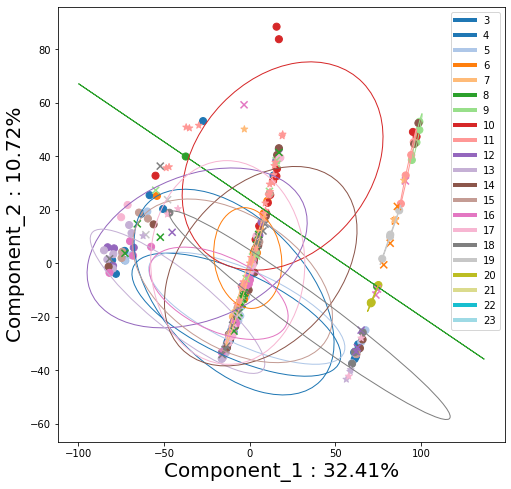

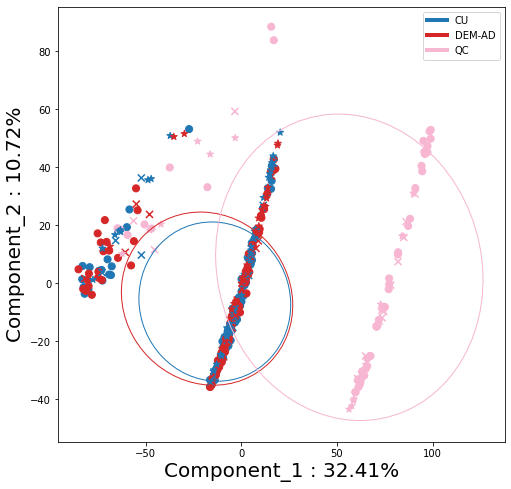

inputs train
inputs valid
inputs test
batches train
batches valid
batches test
labels train
labels valid
labels test


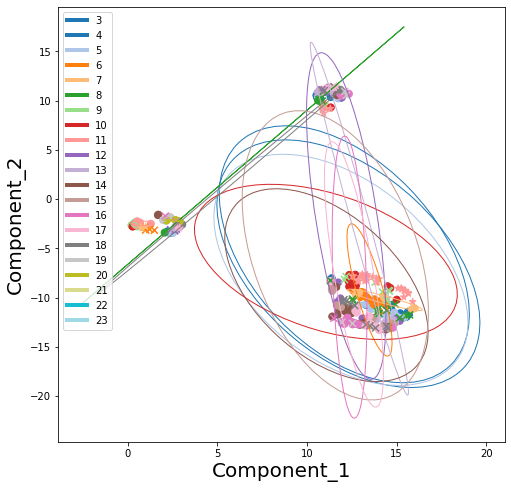

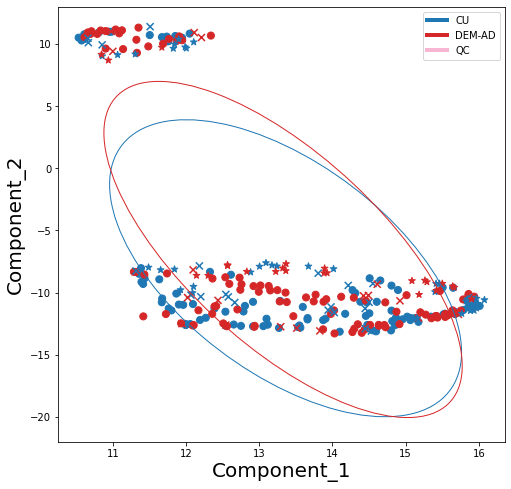

Iteration: 1
-1
valid_score: 0.09602965031278858 h_params: {'tol': 0.9744044165384433, 'max_iter': 933, 'penalty': 'l2', 'C': 9990.405154200935, 'class_weight': 'balanced'}
results/alzheimer/raw/linsvc/2
Iteration: 2
[0.20555555555555555, -0.0045620741787613245, 0.11194627867626022, -0.01848684666616339, 0.18569533817705186]
valid_score: 0.030991791724547735 h_params: {'tol': 0.0038576507737700483, 'max_iter': 389, 'penalty': 'l2', 'C': 9355.39077252125, 'class_weight': 'balanced'}
Iteration: 3
[0.20555555555555555, -0.0045620741787613245, 0.11194627867626022, -0.01848684666616339, 0.18569533817705186]
valid_score: 0.08193041739643084 h_params: {'tol': 0.0017909937393907646, 'max_iter': 525, 'penalty': 'l2', 'C': 2295.7729077210424, 'class_weight': 'balanced'}
Iteration: 4
[0.20555555555555555, -0.0045620741787613245, 0.11194627867626022, -0.01848684666616339, 0.18569533817705186]
valid_score: 0.09843910030938004 h_params: {'tol': 0.4527391991788818, 'max_iter': 458, 'penalty': 'l2', '

In [31]:
%matplotlib inline
metrics = log_fct(copy.deepcopy(data), unique_labels, 'raw', metrics)
log_ord(copy.deepcopy(data), unique_labels, unique_batches)
train_fct(copy.deepcopy(data), n_meta, train_models, 'raw')


In [32]:
if log_stuff:
    # table = pd.DataFrame(columns=list(metrics['raw']['all'].keys()) + ['delta', 'delta_pool'], index=list(metrics.keys()))
    cols = ['qc_aPCC', '[qc_dist/tot_eucl]', 'lisi', 'silhouette', 'kbet', 'shannon', 'adjusted_rand_score', 'adjusted_mutual_info_score']
    # cols_pool = ['pool lisi', 'pool silhouette', 'pool kbet', 'pool shannon', 'pool adjusted_rand_score', 'pool adjusted_mutual_info_score',]
    table = pd.DataFrame(columns=cols, index=list(metrics.keys()))
    # table = table.drop(['qc_dist', 'b_euclidean', 'euclidean', "[b_euclidean/tot_eucl]"], 1)
    for col in cols:
        for row in list(table.index):
            # if 'delta' in col:
            #     table[col][row] = metrics[row][col]
            # else:
            try:
                if isinstance(metrics[row]['all'][col], dict):
                    table[col][row] = metrics[row]['all'][col]["domains"]
                    try:
                        table[f'pool {col}'][row] = metrics[row]['all_pool'][col]["domains"]
                    except:
                        pass
                    # table[col][row]["domains"] = metrics[row]['all'][col]["domains"]
                    # table[col][row]["labels"] = metrics[row]['all'][col]["labels"]
                else:
                    try:
                        table[col][row] = metrics[row]['valid'][col]
                    except:
                        table[col][row] = metrics[row]['all'][col]

            except:
                try:
                    table[col][row] = metrics[row]['all_pool'][col]
                except:
                    table[col][row] = metrics[row]['valid'][col]

table

qc_aPCC [qc_dist/tot_eucl]      lisi silhouette kbet  shannon  \
raw  0.732741           1.460764  2.187153  -0.037908  0.0  2.20917   

    adjusted_rand_score adjusted_mutual_info_score  
raw            0.203972                   0.377329

# Minmax

In [33]:
path = 'data/Alzheimer'
data, unique_labels, unique_batches = get_alzheimer(path, args)
# unique_labels = get_unique_labels(data['labels']['all'])
unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
unique_ages = np.array(['50s', '60s', '70s', '80+'])
unique_genders = np.unique(data['meta']['all'].iloc[:, 1])
n_cats = len(unique_labels)
n_batches = len(unique_batches)
n_ages = len(unique_ages)
n_genders = len(unique_genders)

data['age'] = {}
data['gender'] = {}
meta_age = []
for age in data['meta']['all'].iloc[:, 0]:
    if age < 50:
        meta_age += ['pool']
    elif age < 60:
        meta_age += ['50s']
    elif age < 70:
        meta_age += ['60s']
    elif age < 80:
        meta_age += ['70s']
    else:
        meta_age += ['80+']
data['age']['all'] = np.array(meta_age)
data['gender']['all'] = data['meta']['all'].iloc[:, 1]

data, _ = scale_data('minmax', data, device='cpu')

Mann      pval min    n pvals < 0.05
---------  -  -
CU_DEM-AD  0  1
---------  -  -
ttests
---------  --------  -
CU_DEM-AD  0.142352  0
---------  --------  -
(307, 896)
(307,)
(307,)
(203, 896)
(203,)
(203,)
(40, 896)
(40,)
(40,)
(64, 896)
(64,)
(64,)
inputs train
inputs valid
inputs test
batches train
batches valid
batches test
labels train
labels valid
labels test


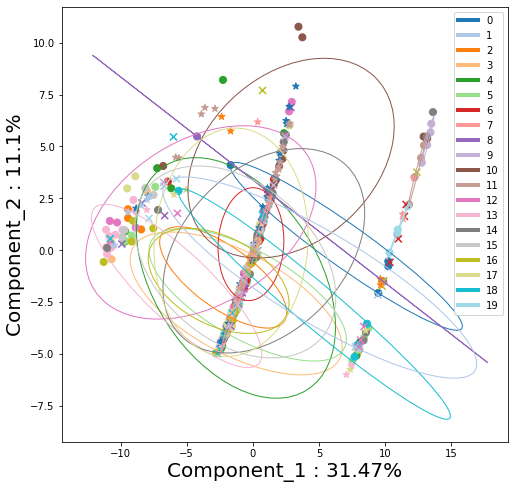

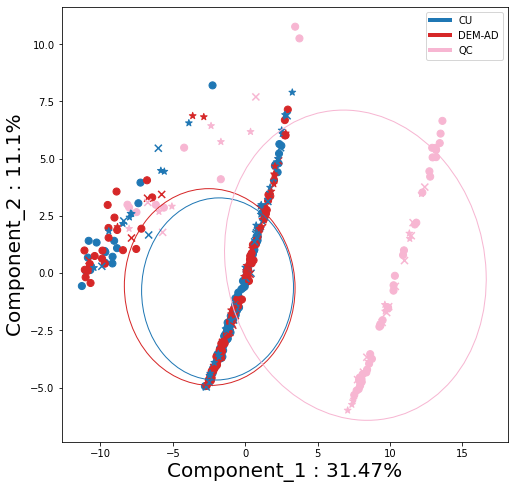

inputs train
inputs valid
inputs test
batches train
batches valid
batches test
labels train
labels valid
labels test


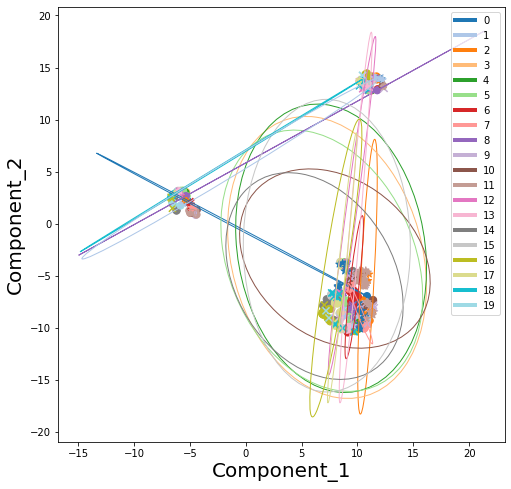

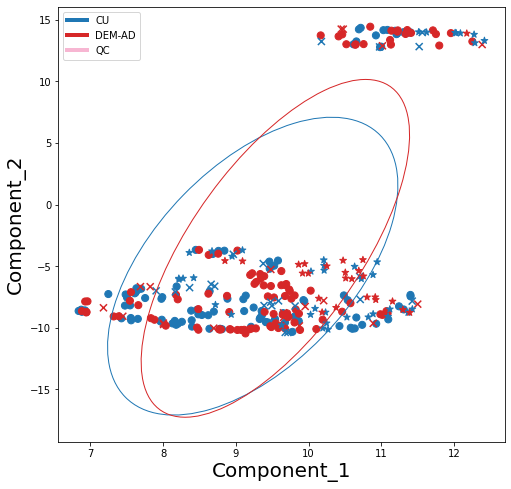

Iteration: 1
-1
valid_score: 0.14471676985241205 h_params: {'tol': 0.9744044165384433, 'max_iter': 933, 'penalty': 'l2', 'C': 9990.405154200935, 'class_weight': 'balanced'}
results/alzheimer/minmax/linsvc/2
Iteration: 2
[0.27372765528585646, 0.23991122933115006, 0.04287464628562721, -0.07142857142857142, 0.23849888978799783]
valid_score: 0.1092419578341917 h_params: {'tol': 0.0038576507737700483, 'max_iter': 389, 'penalty': 'l2', 'C': 9355.39077252125, 'class_weight': 'balanced'}
Iteration: 3
[0.27372765528585646, 0.23991122933115006, 0.04287464628562721, -0.07142857142857142, 0.23849888978799783]
valid_score: 0.1092419578341917 h_params: {'tol': 0.0017909937393907646, 'max_iter': 525, 'penalty': 'l2', 'C': 2295.7729077210424, 'class_weight': 'balanced'}
Iteration: 4
[0.27372765528585646, 0.23991122933115006, 0.04287464628562721, -0.07142857142857142, 0.23849888978799783]
valid_score: 0.14021499912967603 h_params: {'tol': 0.4527391991788818, 'max_iter': 458, 'penalty': 'l2', 'C': 9391.

In [34]:
%matplotlib inline
metrics = log_fct(copy.deepcopy(data), unique_labels, 'minmax', metrics)
log_ord(copy.deepcopy(data), unique_labels, unique_batches)
train_fct(copy.deepcopy(data), n_meta, train_models, 'minmax')


# Minmax per batch

In [35]:
path = 'data/Alzheimer'
data, unique_labels, unique_batches = get_alzheimer(path, args)
# unique_labels = get_unique_labels(data['labels']['all'])
unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
unique_ages = np.array(['50s', '60s', '70s', '80+'])
unique_genders = np.unique(data['meta']['all'].iloc[:, 1])
n_cats = len(unique_labels)
n_batches = len(unique_batches)
n_ages = len(unique_ages)
n_genders = len(unique_genders)

data['age'] = {}
data['gender'] = {}
meta_age = []
for age in data['meta']['all'].iloc[:, 0]:
    if age < 50:
        meta_age += ['pool']
    elif age < 60:
        meta_age += ['50s']
    elif age < 70:
        meta_age += ['60s']
    elif age < 80:
        meta_age += ['70s']
    else:
        meta_age += ['80+']
data['age']['all'] = np.array(meta_age)
data['gender']['all'] = data['meta']['all'].iloc[:, 1]

data, _ = scale_data('minmax_per_batch', data, device='cpu')

Mann      pval min    n pvals < 0.05
---------  -  -
CU_DEM-AD  0  1
---------  -  -
ttests
---------  ---------  -
CU_DEM-AD  0.0259863  1
---------  ---------  -
(307, 896)
(307,)
(307,)
(203, 896)
(203,)
(203,)
(40, 896)
(40,)
(40,)
(64, 896)
(64,)
(64,)
inputs train
inputs valid
inputs test
batches train
batches valid
batches test
labels train
labels valid
labels test


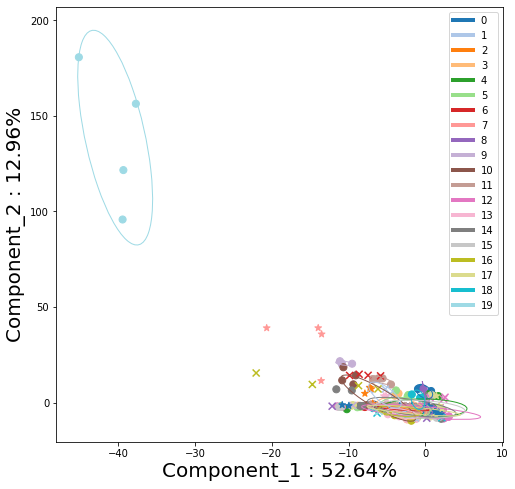

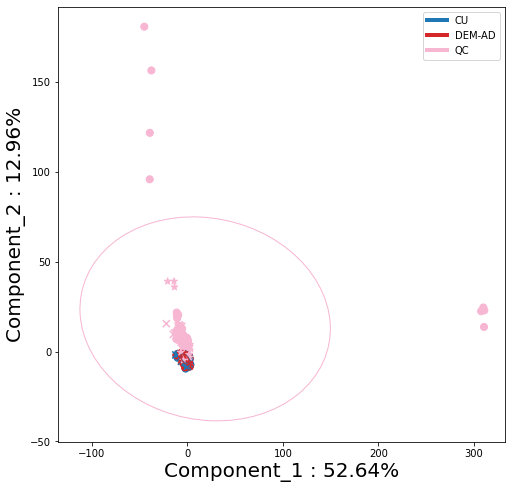

inputs train
inputs valid
inputs test
batches train
batches valid
batches test
labels train
labels valid
labels test


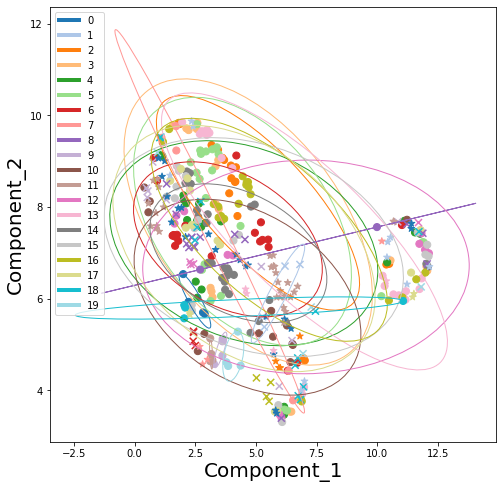

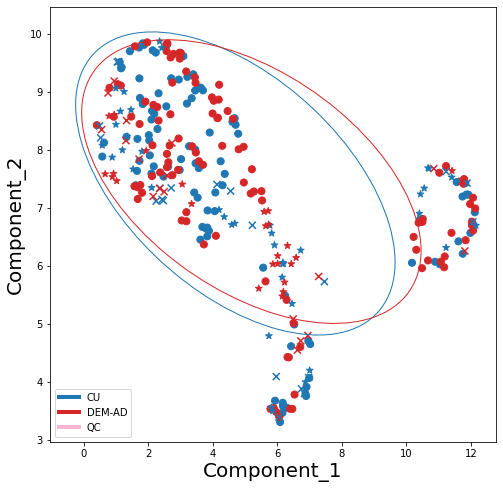

Iteration: 1
-1
valid_score: -0.06931426575760948 h_params: {'tol': 0.9744044165384433, 'max_iter': 933, 'penalty': 'l2', 'C': 9990.405154200935, 'class_weight': 'balanced'}
results/alzheimer/minmax_per_batch/linsvc/2
Iteration: 2
[0.19364916731037085, -0.2853584531404519, -0.1197131421939065, -0.12111303541295121, -0.014035865351108649]
valid_score: -0.014155517858522454 h_params: {'tol': 0.0038576507737700483, 'max_iter': 389, 'penalty': 'l2', 'C': 9355.39077252125, 'class_weight': 'balanced'}
results/alzheimer/minmax_per_batch/linsvc/2
Iteration: 3
[0.18401748249129446, -0.03711537444790452, -0.08574929257125442, -0.1749635530559413, 0.04303314829119352]
valid_score: -0.014155517858522454 h_params: {'tol': 0.0017909937393907646, 'max_iter': 525, 'penalty': 'l2', 'C': 2295.7729077210424, 'class_weight': 'balanced'}
Iteration: 4
[0.18401748249129446, -0.03711537444790452, -0.08574929257125442, -0.1749635530559413, 0.04303314829119352]
valid_score: 0.0033976969875866127 h_params: {'tol

In [36]:
%matplotlib inline
metrics = log_fct(copy.deepcopy(data), unique_labels, 'minmax_per_batch', metrics)
log_ord(copy.deepcopy(data), unique_labels, unique_batches)
train_fct(copy.deepcopy(data), n_meta, train_models, 'minmax_per_batch')


# Standard

In [37]:
path = 'data/Alzheimer'
data, unique_labels, unique_batches = get_alzheimer(path, args)
# unique_labels = get_unique_labels(data['labels']['all'])
unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
unique_ages = np.array(['50s', '60s', '70s', '80+'])
unique_genders = np.unique(data['meta']['all'].iloc[:, 1])
n_cats = len(unique_labels)
n_batches = len(unique_batches)
n_ages = len(unique_ages)
n_genders = len(unique_genders)

data['age'] = {}
data['gender'] = {}
meta_age = []
for age in data['meta']['all'].iloc[:, 0]:
    if age < 50:
        meta_age += ['pool']
    elif age < 60:
        meta_age += ['50s']
    elif age < 70:
        meta_age += ['60s']
    elif age < 80:
        meta_age += ['70s']
    else:
        meta_age += ['80+']
data['age']['all'] = np.array(meta_age)
data['gender']['all'] = data['meta']['all'].iloc[:, 1]

data, _ = scale_data('standard', data, device='cpu')

Mann      pval min    n pvals < 0.05
---------  -  -
CU_DEM-AD  0  1
---------  -  -
ttests
---------  --------  -
CU_DEM-AD  0.142352  0
---------  --------  -
(307, 896)
(307,)
(307,)
(203, 896)
(203,)
(203,)
(40, 896)
(40,)
(40,)
(64, 896)
(64,)
(64,)
inputs train
inputs valid
inputs test
batches train
batches valid
batches test
labels train
labels valid
labels test


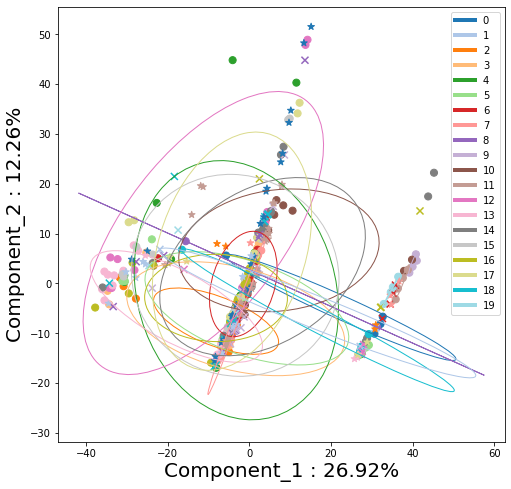

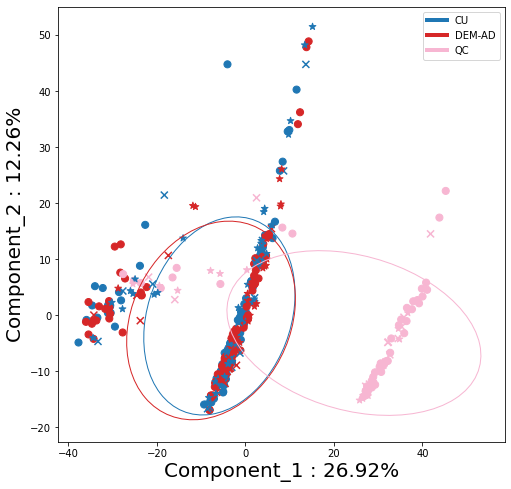

inputs train
inputs valid
inputs test
batches train
batches valid
batches test
labels train
labels valid
labels test


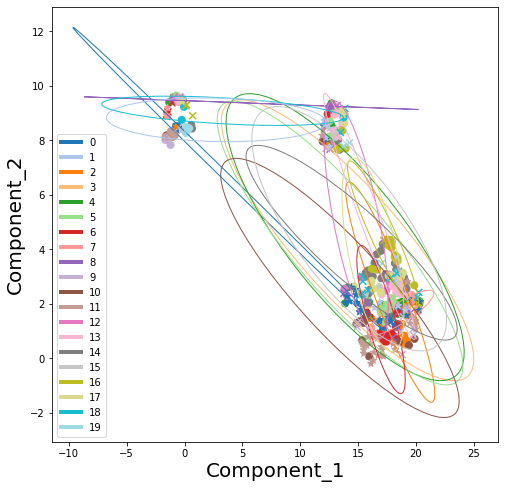

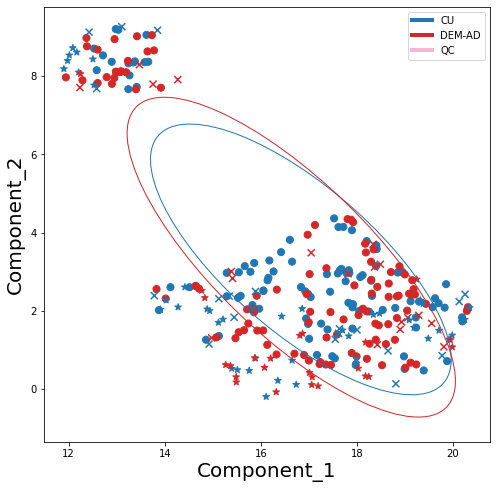

Iteration: 1
-1
valid_score: 0.10576354047489231 h_params: {'tol': 0.9744044165384433, 'max_iter': 933, 'penalty': 'l2', 'C': 9990.405154200935, 'class_weight': 'balanced'}
results/alzheimer/standard/linsvc/2
Iteration: 2
[0.1, 0.1854551190732577, 0.11761080896354373, 0.022587697572631283, 0.10316407676502881]
valid_score: 0.1017760163591456 h_params: {'tol': 0.0038576507737700483, 'max_iter': 389, 'penalty': 'l2', 'C': 9355.39077252125, 'class_weight': 'balanced'}
Iteration: 3
[0.1, 0.1854551190732577, 0.11761080896354373, 0.022587697572631283, 0.10316407676502881]
valid_score: 0.1017760163591456 h_params: {'tol': 0.0017909937393907646, 'max_iter': 525, 'penalty': 'l2', 'C': 2295.7729077210424, 'class_weight': 'balanced'}
Iteration: 4
[0.1, 0.1854551190732577, 0.11761080896354373, 0.022587697572631283, 0.10316407676502881]
valid_score: 0.08829115534496086 h_params: {'tol': 0.4527391991788818, 'max_iter': 458, 'penalty': 'l2', 'C': 9391.27795510847, 'class_weight': 'balanced'}
Iteratio

In [38]:
%matplotlib inline
metrics = log_fct(copy.deepcopy(data), unique_labels, 'standard', metrics)
log_ord(copy.deepcopy(data), unique_labels, unique_batches)
train_fct(copy.deepcopy(data), n_meta, train_models, 'standard')


# Standard per batch

In [39]:
path = 'data/Alzheimer'
data, unique_labels, unique_batches = get_alzheimer(path, args)
# unique_labels = get_unique_labels(data['labels']['all'])
unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
unique_ages = np.array(['50s', '60s', '70s', '80+'])
unique_genders = np.unique(data['meta']['all'].iloc[:, 1])
n_cats = len(unique_labels)
n_batches = len(unique_batches)
n_ages = len(unique_ages)
n_genders = len(unique_genders)

data['age'] = {}
data['gender'] = {}
meta_age = []
for age in data['meta']['all'].iloc[:, 0]:
    if age < 50:
        meta_age += ['pool']
    elif age < 60:
        meta_age += ['50s']
    elif age < 70:
        meta_age += ['60s']
    elif age < 80:
        meta_age += ['70s']
    else:
        meta_age += ['80+']
data['age']['all'] = np.array(meta_age)
data['gender']['all'] = data['meta']['all'].iloc[:, 1]

data, _ = scale_data('standard_per_batch', data, device='cpu')

Mann      pval min    n pvals < 0.05
---------  -  -
CU_DEM-AD  0  1
---------  -  -
ttests
---------  ---------  -
CU_DEM-AD  0.0898001  0
---------  ---------  -
(307, 896)
(307,)
(307,)
(203, 896)
(203,)
(203,)
(40, 896)
(40,)
(40,)
(64, 896)
(64,)
(64,)
inputs train
inputs valid
inputs test
batches train
batches valid
batches test
labels train
labels valid
labels test


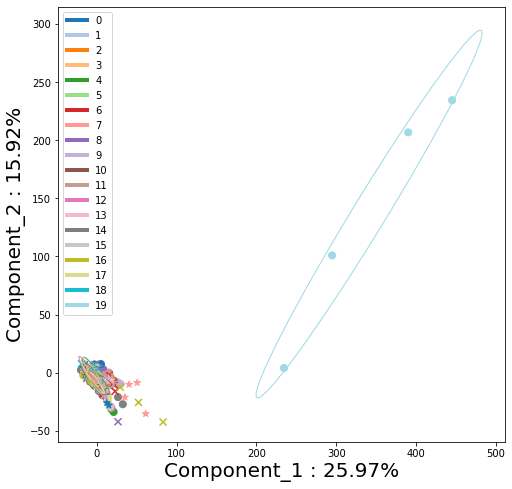

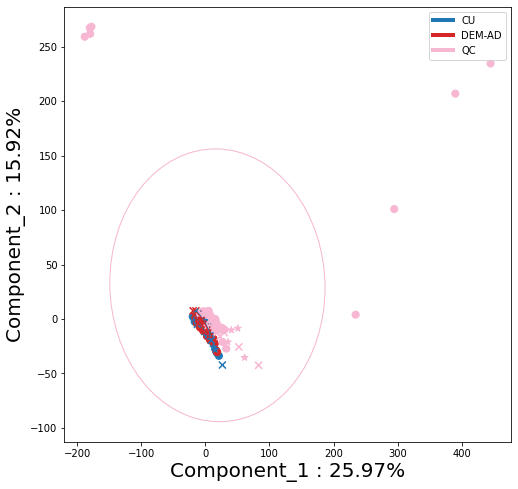

inputs train
inputs valid
inputs test
batches train
batches valid
batches test
labels train
labels valid
labels test


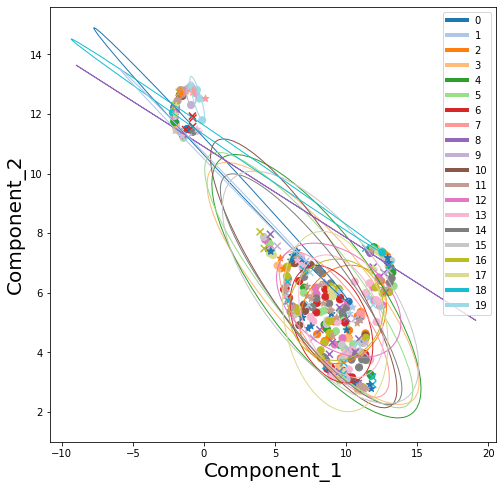

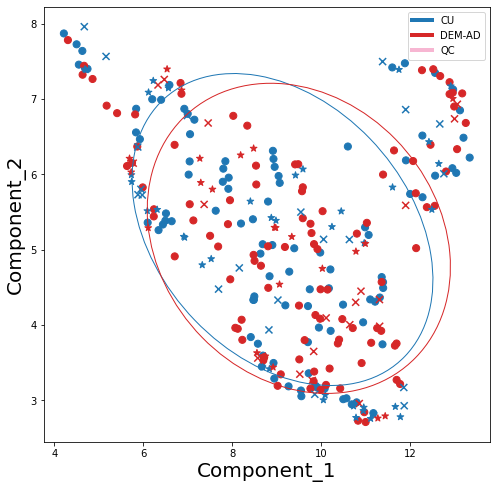

Iteration: 1
-1
valid_score: -0.01597564761290922 h_params: {'tol': 0.9744044165384433, 'max_iter': 933, 'penalty': 'l2', 'C': 9990.405154200935, 'class_weight': 'balanced'}
results/alzheimer/standard_per_batch/linsvc/2
Iteration: 2
[0.18977461833002043, -0.1035927412705931, 0.09207338730881487, -0.19611613513818404, -0.062017367294604234]
valid_score: 0.018351321318792295 h_params: {'tol': 0.0038576507737700483, 'max_iter': 389, 'penalty': 'l2', 'C': 9355.39077252125, 'class_weight': 'balanced'}
results/alzheimer/standard_per_batch/linsvc/2
Iteration: 3
[0.18977461833002043, -0.1035927412705931, 0.12433647422831891, -0.08781252166427611, -0.030949223029508643]
valid_score: 0.017028310845604282 h_params: {'tol': 0.0017909937393907646, 'max_iter': 525, 'penalty': 'l2', 'C': 2295.7729077210424, 'class_weight': 'balanced'}
Iteration: 4
[0.18977461833002043, -0.1035927412705931, 0.12433647422831891, -0.08781252166427611, -0.030949223029508643]
valid_score: -0.027427064994732443 h_params: {

In [40]:
%matplotlib inline
metrics = log_fct(copy.deepcopy(data), unique_labels, 'standard_per_batch', metrics)
log_ord(copy.deepcopy(data), unique_labels, unique_batches)
train_fct(copy.deepcopy(data), n_meta, train_models, 'standard_per_batch')


# Robust

In [41]:
path = 'data/Alzheimer'
data, unique_labels, unique_batches = get_alzheimer(path, args)
# unique_labels = get_unique_labels(data['labels']['all'])
unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
unique_ages = np.array(['50s', '60s', '70s', '80+'])
unique_genders = np.unique(data['meta']['all'].iloc[:, 1])
n_cats = len(unique_labels)
n_batches = len(unique_batches)
n_ages = len(unique_ages)
n_genders = len(unique_genders)

data['age'] = {}
data['gender'] = {}
meta_age = []
for age in data['meta']['all'].iloc[:, 0]:
    if age < 50:
        meta_age += ['pool']
    elif age < 60:
        meta_age += ['50s']
    elif age < 70:
        meta_age += ['60s']
    elif age < 80:
        meta_age += ['70s']
    else:
        meta_age += ['80+']
data['age']['all'] = np.array(meta_age)
data['gender']['all'] = data['meta']['all'].iloc[:, 1]

data, _ = scale_data('robust', data, device='cpu')

Mann      pval min    n pvals < 0.05
---------  -  -
CU_DEM-AD  0  1
---------  -  -
ttests
---------  --------  -
CU_DEM-AD  0.142352  0
---------  --------  -
(307, 896)
(307,)
(307,)
(203, 896)
(203,)
(203,)
(40, 896)
(40,)
(40,)
(64, 896)
(64,)
(64,)
inputs train
inputs valid
inputs test
batches train
batches valid
batches test
labels train
labels valid
labels test


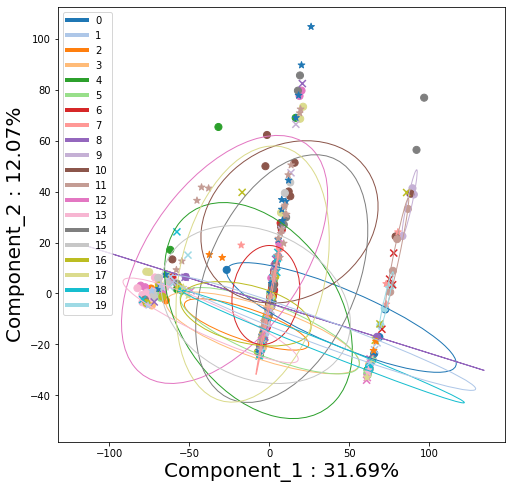

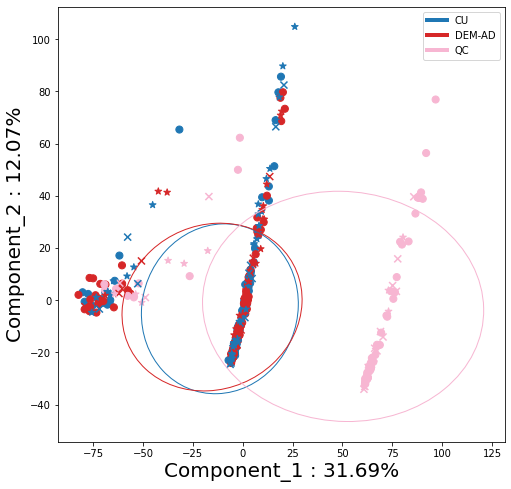

inputs train
inputs valid
inputs test
batches train
batches valid
batches test
labels train
labels valid
labels test


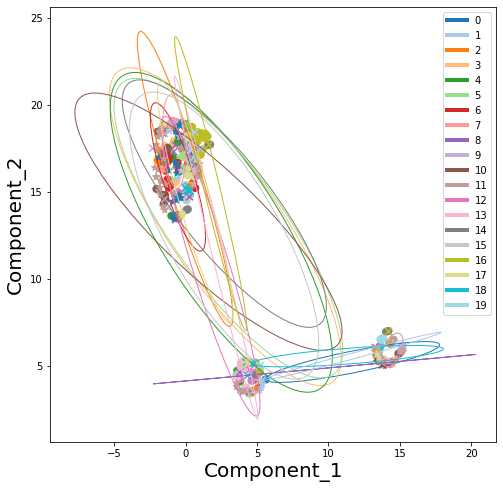

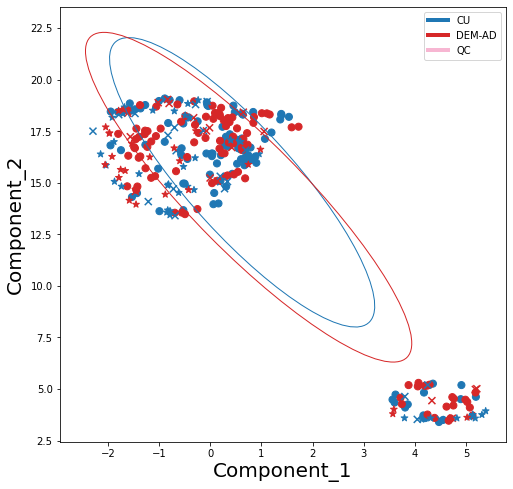

Iteration: 1
-1
valid_score: 0.0281394753892955 h_params: {'tol': 0.9744044165384433, 'max_iter': 933, 'penalty': 'l2', 'C': 9990.405154200935, 'class_weight': 'balanced'}
results/alzheimer/robust/linsvc/2
Iteration: 2
[0.05750546327852952, -0.1446033825636452, 0.02767546517312798, 0.07568562769081418, 0.12443420336765103]
valid_score: 0.029076993518040918 h_params: {'tol': 0.0038576507737700483, 'max_iter': 389, 'penalty': 'l2', 'C': 9355.39077252125, 'class_weight': 'balanced'}
results/alzheimer/robust/linsvc/2
Iteration: 3
[0.029027606770736975, -0.11213565339313257, -0.0037020790049563574, 0.07715167498104596, 0.15504341823651058]
valid_score: 0.029076993518040918 h_params: {'tol': 0.0017909937393907646, 'max_iter': 525, 'penalty': 'l2', 'C': 2295.7729077210424, 'class_weight': 'balanced'}
Iteration: 4
[0.029027606770736975, -0.11213565339313257, -0.0037020790049563574, 0.07715167498104596, 0.15504341823651058]
valid_score: 0.036639466254735756 h_params: {'tol': 0.4527391991788818,

In [42]:
%matplotlib inline
metrics = log_fct(copy.deepcopy(data), unique_labels, 'robust', metrics)
log_ord(copy.deepcopy(data), unique_labels, unique_batches)
train_fct(copy.deepcopy(data), n_meta, train_models, 'robust')


# Robust per batch

In [43]:
path = 'data/Alzheimer'
data, unique_labels, unique_batches = get_alzheimer(path, args)
# unique_labels = get_unique_labels(data['labels']['all'])
unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
unique_ages = np.array(['50s', '60s', '70s', '80+'])
unique_genders = np.unique(data['meta']['all'].iloc[:, 1])
n_cats = len(unique_labels)
n_batches = len(unique_batches)
n_ages = len(unique_ages)
n_genders = len(unique_genders)

data['age'] = {}
data['gender'] = {}
meta_age = []
for age in data['meta']['all'].iloc[:, 0]:
    if age < 50:
        meta_age += ['pool']
    elif age < 60:
        meta_age += ['50s']
    elif age < 70:
        meta_age += ['60s']
    elif age < 80:
        meta_age += ['70s']
    else:
        meta_age += ['80+']
data['age']['all'] = np.array(meta_age)
data['gender']['all'] = data['meta']['all'].iloc[:, 1]

data, _ = scale_data('robust_per_batch', data, device='cpu')

Mann      pval min    n pvals < 0.05
---------  -  -
CU_DEM-AD  0  1
---------  -  -
ttests
---------  --------  -
CU_DEM-AD  0.491553  0
---------  --------  -
(307, 896)
(307,)
(307,)
(203, 896)
(203,)
(203,)
(40, 896)
(40,)
(40,)
(64, 896)
(64,)
(64,)
inputs train
inputs valid
inputs test
batches train
batches valid
batches test
labels train
labels valid
labels test


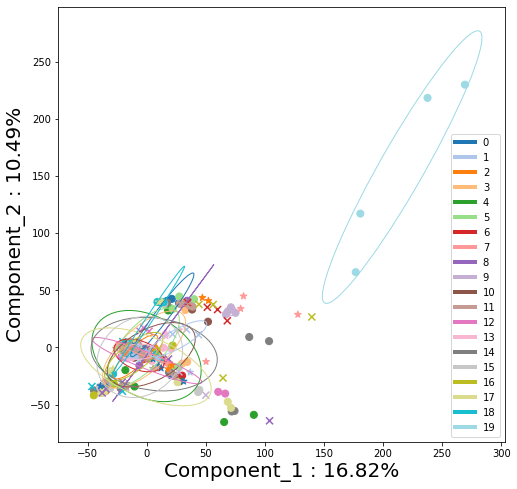

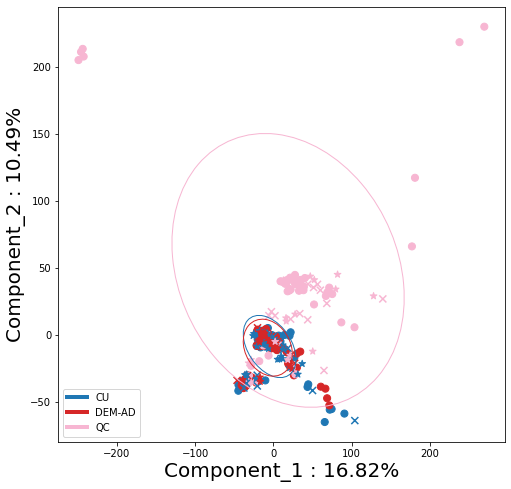

inputs train
inputs valid
inputs test
batches train
batches valid
batches test
labels train
labels valid
labels test


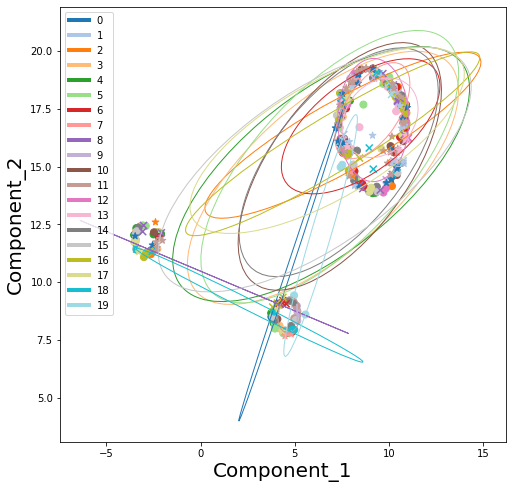

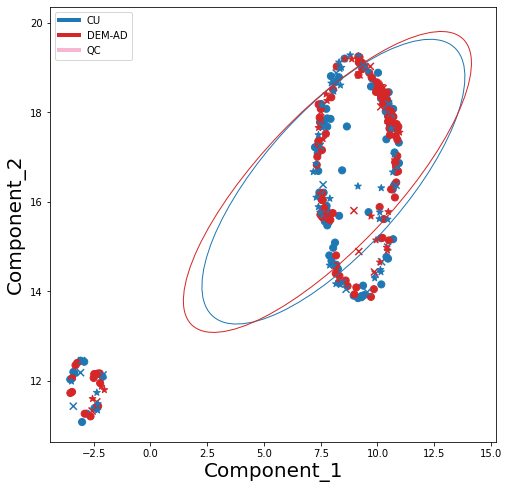

Iteration: 1
-1
valid_score: -0.1083843068496138 h_params: {'tol': 0.9744044165384433, 'max_iter': 933, 'penalty': 'l2', 'C': 9990.405154200935, 'class_weight': 'balanced'}
results/alzheimer/robust_per_batch/linsvc/2
Iteration: 2
[-0.1653771250685383, -0.2549562817969105, 0.12126781251816648, -0.08781252166427611, -0.15504341823651058]
valid_score: -0.10797148597501796 h_params: {'tol': 0.0038576507737700483, 'max_iter': 389, 'penalty': 'l2', 'C': 9355.39077252125, 'class_weight': 'balanced'}
results/alzheimer/robust_per_batch/linsvc/2
Iteration: 3
[-0.1653771250685383, -0.2549562817969105, 0.12333191689114564, -0.08781252166427611, -0.15504341823651058]
valid_score: -0.10797148597501796 h_params: {'tol': 0.0017909937393907646, 'max_iter': 525, 'penalty': 'l2', 'C': 2295.7729077210424, 'class_weight': 'balanced'}
Iteration: 4
[-0.1653771250685383, -0.2549562817969105, 0.12333191689114564, -0.08781252166427611, -0.15504341823651058]
valid_score: -0.10532363934821087 h_params: {'tol': 0.

In [44]:
%matplotlib inline
metrics = log_fct(copy.deepcopy(data), unique_labels, 'robust_per_batch', metrics)
log_ord(copy.deepcopy(data), unique_labels, unique_batches)
train_fct(copy.deepcopy(data), n_meta, train_models, 'robust_per_batch')


# Combat

In [45]:
path = 'data/Alzheimer'
data, unique_labels, unique_batches = get_alzheimer(path, args)
# unique_labels = get_unique_labels(data['labels']['all'])
# unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
unique_ages = np.array(['50s', '60s', '70s', '80+'])
unique_genders = np.unique(data['meta']['all'].iloc[:, 1])
n_cats = len(unique_labels)
n_batches = len(unique_batches)
n_ages = len(unique_ages)
n_genders = len(unique_genders)

data['age'] = {}
data['gender'] = {}
meta_age = []
for age in data['meta']['all'].iloc[:, 0]:
    if age < 50:
        meta_age += ['pool']
    elif age < 60:
        meta_age += ['50s']
    elif age < 70:
        meta_age += ['60s']
    elif age < 80:
        meta_age += ['70s']
    else:
        meta_age += ['80+']
data['age']['all'] = np.array(meta_age)
data['gender']['all'] = data['meta']['all'].iloc[:, 1]


print(data['inputs']['train'].shape)
print(data['inputs']['test'].shape)
print(data['inputs']['valid'].shape)
print(data['inputs']['all'].shape)
data = remove_batch_effect(get_berm('combat'), data)
print(data['inputs']['all'].shape)

# data['inputs']['all'] = data['inputs']['all'].fillna(0)
#data['inputs']['train'][np.isnan(data['inputs']['train'])] = 0
# data['inputs']['train_pool'][np.isnan(data['inputs']['train_pool'])] = 0
# data['inputs']['valid'][np.isnan(data['inputs']['valid'])] = 0
# data['inputs']['valid_pool'][np.isnan(data['inputs']['valid_pool'])] = 0
# data['inputs']['test'][np.isnan(data['inputs']['test'])] = 0
# data['inputs']['test_pool'][np.isnan(data['inputs']['test_pool'])] = 0


(203, 896)
(64, 896)
(40, 896)
(307, 896)
not with classes!


R[write to console]: Found21batches

R[write to console]: Adjusting for0covariate(s) or covariate level(s)

R[write to console]: Standardizing Data across genes

R[write to console]: Fitting L/S model and finding priors

R[write to console]: Finding parametric adjustments

R[write to console]: Adjusting the Data




train 0
valid 203
test 243
train_pool 307
valid_pool 357
test_pool 373
(307, 896)


Mann      pval min    n pvals < 0.05
---------  -  -
CU_DEM-AD  0  1
---------  -  -
ttests
---------  -------  -
CU_DEM-AD  0.17929  0
---------  -------  -
(307, 896)
(307,)
(307,)
(203, 896)
(203,)
(203,)
(40, 896)
(40,)
(40,)
(64, 896)
(64,)
(64,)
inputs train
inputs valid
inputs test
batches train
batches valid
batches test
labels train
labels valid
labels test


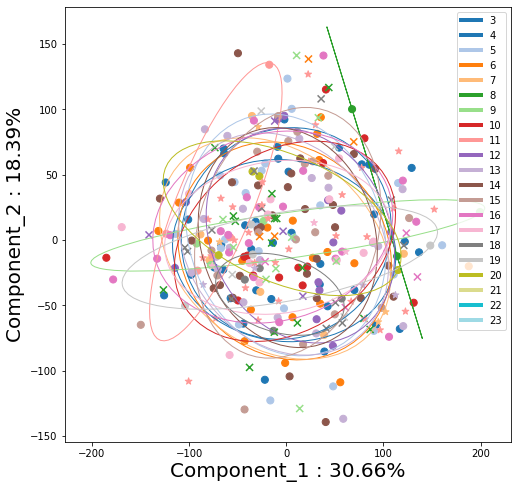

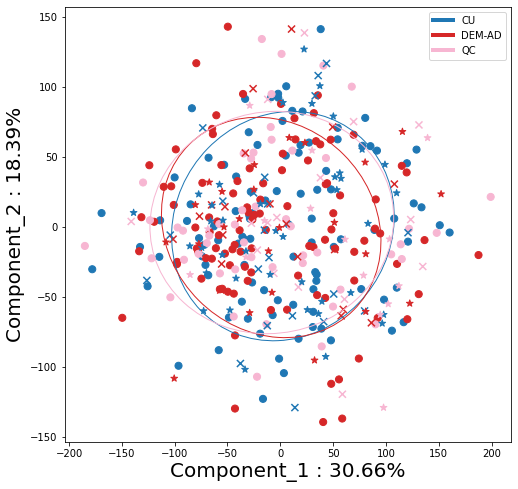

inputs train
inputs valid
inputs test
batches train
batches valid
batches test
labels train
labels valid
labels test


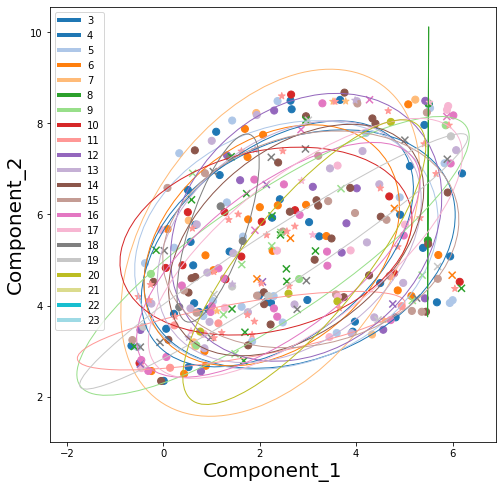

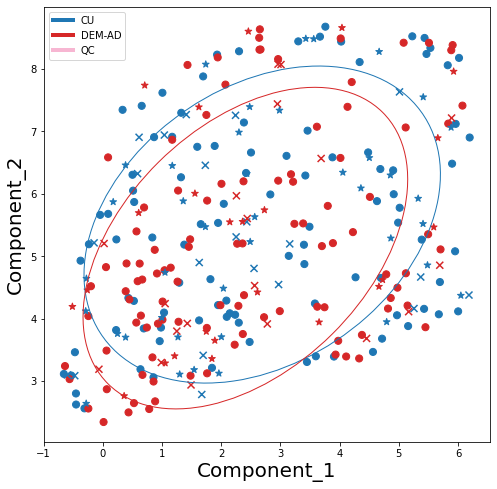

Iteration: 1
-1
valid_score: -0.01300807657888729 h_params: {'tol': 0.9744044165384433, 'max_iter': 933, 'penalty': 'l2', 'C': 9990.405154200935, 'class_weight': 'balanced'}
results/alzheimer/combat/linsvc/2
Iteration: 2
[0.01114729533239837, -0.05773502691896258, 0.06478638258673626, -0.0625, -0.020739033894608506]
valid_score: -0.0386790700317381 h_params: {'tol': 0.0038576507737700483, 'max_iter': 389, 'penalty': 'l2', 'C': 9355.39077252125, 'class_weight': 'balanced'}
Iteration: 3
[0.01114729533239837, -0.05773502691896258, 0.06478638258673626, -0.0625, -0.020739033894608506]
valid_score: -0.01990499283999268 h_params: {'tol': 0.0017909937393907646, 'max_iter': 525, 'penalty': 'l2', 'C': 2295.7729077210424, 'class_weight': 'balanced'}
Iteration: 4
[0.01114729533239837, -0.05773502691896258, 0.06478638258673626, -0.0625, -0.020739033894608506]
valid_score: -0.06793445163558054 h_params: {'tol': 0.4527391991788818, 'max_iter': 458, 'penalty': 'l2', 'C': 9391.27795510847, 'class_weigh

In [46]:
%matplotlib inline
metrics = log_fct(copy.deepcopy(data), unique_labels, 'combat', metrics)
log_ord(copy.deepcopy(data), unique_labels, unique_batches)
train_fct(copy.deepcopy(data), n_meta, train_models, 'combat')


# pyCombat

In [47]:
from combat.pycombat import pycombat
path = 'data/Alzheimer'
data, unique_labels, unique_batches = get_alzheimer(path, args)
# unique_labels = get_unique_labels(data['labels']['all'])
unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
unique_ages = np.array(['50s', '60s', '70s', '80+'])
unique_genders = np.unique(data['meta']['all'].iloc[:, 1])
n_cats = len(unique_labels)
n_batches = len(unique_batches)
n_ages = len(unique_ages)
n_genders = len(unique_genders)

data['age'] = {}
data['gender'] = {}
meta_age = []
for age in data['meta']['all'].iloc[:, 0]:
    if age < 50:
        meta_age += ['pool']
    elif age < 60:
        meta_age += ['50s']
    elif age < 70:
        meta_age += ['60s']
    elif age < 80:
        meta_age += ['70s']
    else:
        meta_age += ['80+']
data['age']['all'] = np.array(meta_age)
data['gender']['all'] = data['meta']['all'].iloc[:, 1]

data = use_pycombat(pycombat, data)


Found 21 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


Mann      pval min    n pvals < 0.05
---------  -  -
CU_DEM-AD  0  1
---------  -  -
ttests
---------  --------  -
CU_DEM-AD  0.136166  0
---------  --------  -
(307, 896)
(307,)
(307,)
(203, 896)
(203,)
(203,)
(40, 896)
(40,)
(40,)
(64, 896)
(64,)
(64,)
inputs train
inputs valid
inputs test
batches train
batches valid
batches test
labels train
labels valid
labels test


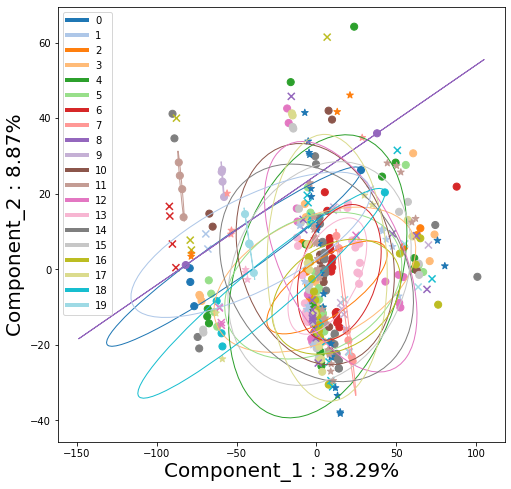

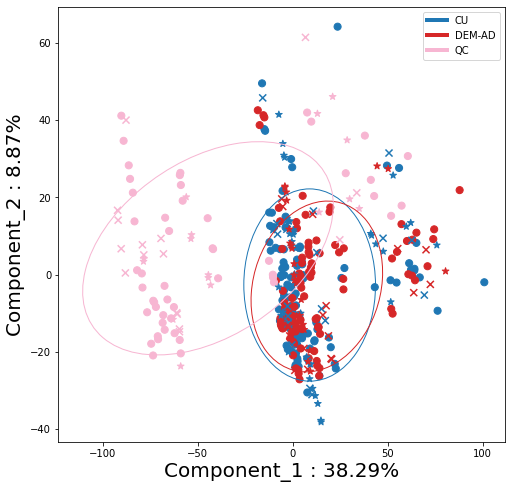

inputs train
inputs valid
inputs test
batches train
batches valid
batches test
labels train
labels valid
labels test


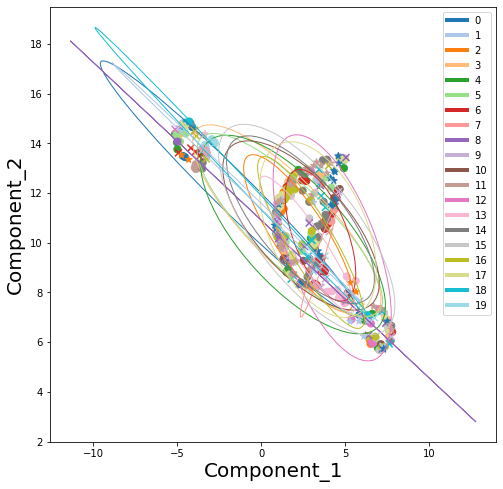

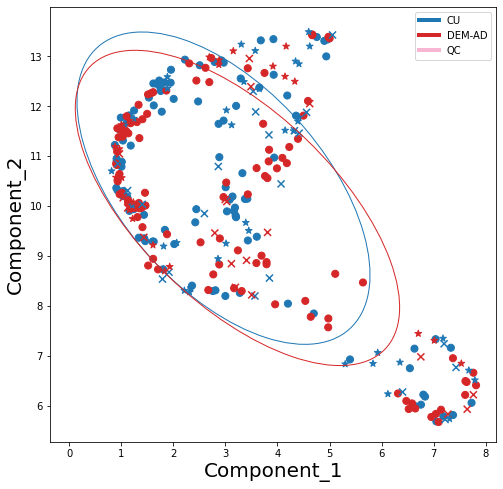

Iteration: 1
-1
valid_score: 0.030885187570074062 h_params: {'tol': 0.9744044165384433, 'max_iter': 933, 'penalty': 'l2', 'C': 9990.405154200935, 'class_weight': 'balanced'}
results/alzheimer/pycombat/linsvc/2
Iteration: 2
[0.15674907656197967, 0.04629865829197633, 0.007575540190785703, -0.21124075543088197, 0.15504341823651058]
valid_score: 0.054568937684231454 h_params: {'tol': 0.0038576507737700483, 'max_iter': 389, 'penalty': 'l2', 'C': 9355.39077252125, 'class_weight': 'balanced'}
results/alzheimer/pycombat/linsvc/2
Iteration: 3
[0.2593586450510279, 0.026785714285714284, -0.018565266430812643, -0.21124075543088197, 0.21650635094610968]
valid_score: 0.014241409883935732 h_params: {'tol': 0.0017909937393907646, 'max_iter': 525, 'penalty': 'l2', 'C': 2295.7729077210424, 'class_weight': 'balanced'}
Iteration: 4
[0.2593586450510279, 0.026785714285714284, -0.018565266430812643, -0.21124075543088197, 0.21650635094610968]
valid_score: 0.03711824705466623 h_params: {'tol': 0.45273919917888

In [48]:
%matplotlib inline
metrics = log_fct(copy.deepcopy(data), unique_labels, 'pycombat', metrics)
log_ord(copy.deepcopy(data), unique_labels, unique_batches)
train_fct(copy.deepcopy(data), n_meta, train_models, 'pycombat')


# Harmony

In [49]:
path = 'data/Alzheimer'
data, unique_labels, unique_batches = get_alzheimer(path, args)
unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
unique_ages = np.array(['50s', '60s', '70s', '80+'])
unique_genders = np.unique(data['meta']['all'].iloc[:, 1])
n_cats = len(unique_labels)
n_batches = len(unique_batches)
n_ages = len(unique_ages)
n_genders = len(unique_genders)
data['age'] = {}
data['gender'] = {}
meta_age = []
for age in data['meta']['all'].iloc[:, 0]:
    if age < 50:
        meta_age += ['pool']
    elif age < 60:
        meta_age += ['50s']
    elif age < 70:
        meta_age += ['60s']
    elif age < 80:
        meta_age += ['70s']
    else:
        meta_age += ['80+']
data['age']['all'] = np.array(meta_age)
data['gender']['all'] = data['meta']['all'].iloc[:, 1]

data['inputs']['all'].iloc[:] = minmax_scaler.fit_transform(data['inputs']['all'])
data['inputs']['all_pool'].iloc[:] = minmax_scaler.transform(data['inputs']['all_pool'])
data['inputs']['train'].iloc[:] = minmax_scaler.transform(data['inputs']['train'])
data['inputs']['train_pool'].iloc[:] = minmax_scaler.transform(data['inputs']['train_pool'])
data['inputs']['valid'].iloc[:] = minmax_scaler.transform(data['inputs']['valid'])
data['inputs']['valid_pool'].iloc[:] = minmax_scaler.transform(data['inputs']['valid_pool'])
data['inputs']['test'].iloc[:] = minmax_scaler.transform(data['inputs']['test'])
data['inputs']['test_pool'].iloc[:] = minmax_scaler.transform(data['inputs']['test_pool'])
data = remove_batch_effect(get_berm('harmony'), data)



R[write to console]: Transposing data matrix

R[write to console]: Hard k-means centroids initialization
R[write to console]: 

R[write to console]: Harmony 1/10

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]

train 0
valid 203
test 243
train_pool 307
valid_pool 357
test_pool 373


Mann      pval min    n pvals < 0.05
---------  -  -
CU_DEM-AD  0  1
---------  -  -
ttests
---------  --------  -
CU_DEM-AD  0.184617  0
---------  --------  -
(307, 896)
(307,)
(307,)
(203, 896)
(203,)
(203,)
(40, 896)
(40,)
(40,)
(64, 896)
(64,)
(64,)
inputs train
inputs valid
inputs test
batches train
batches valid
batches test
labels train
labels valid
labels test


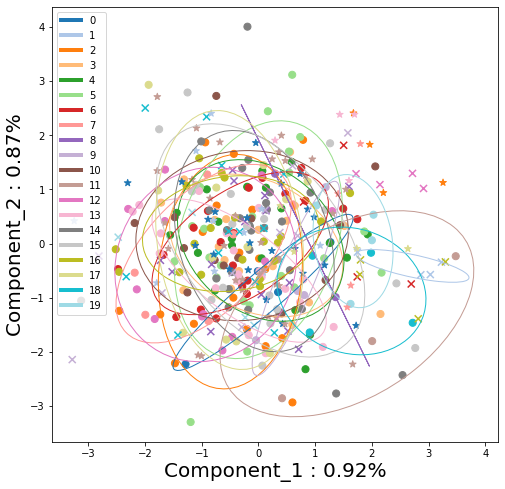

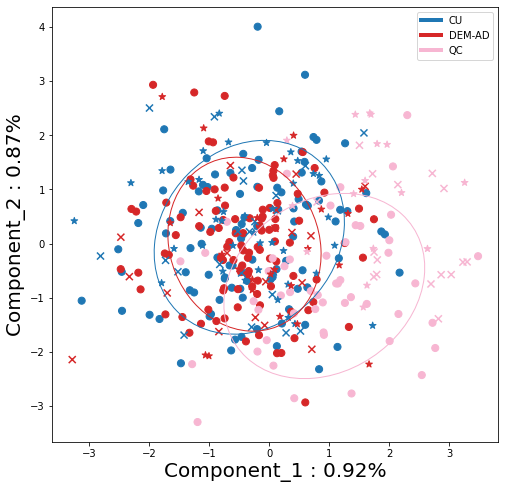

inputs train
inputs valid
inputs test
batches train
batches valid
batches test
labels train
labels valid
labels test


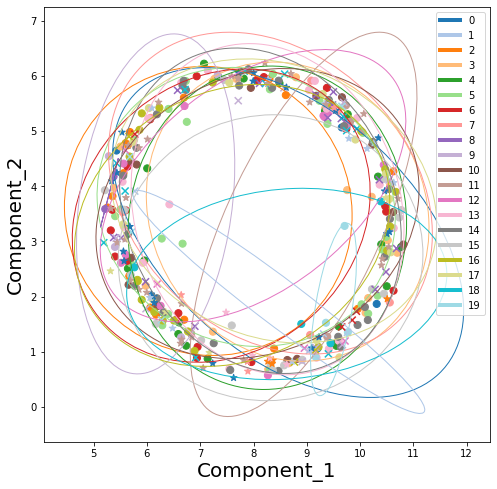

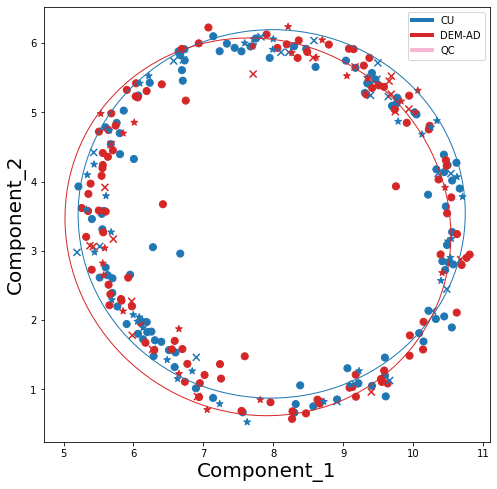

Iteration: 1
-1
valid_score: 0.05351759720086817 h_params: {'tol': 0.9744044165384433, 'max_iter': 933, 'penalty': 'l2', 'C': 9990.405154200935, 'class_weight': 'balanced'}
results/alzheimer/harmony/linsvc/2
Iteration: 2
[-0.16255459791612706, 0.10036563193274914, 0.1325719533387498, -0.05038878558710019, 0.24759378423606915]
valid_score: 0.04716777446495417 h_params: {'tol': 0.0038576507737700483, 'max_iter': 389, 'penalty': 'l2', 'C': 9355.39077252125, 'class_weight': 'balanced'}
Iteration: 3
[-0.16255459791612706, 0.10036563193274914, 0.1325719533387498, -0.05038878558710019, 0.24759378423606915]
valid_score: 0.04716777446495417 h_params: {'tol': 0.0017909937393907646, 'max_iter': 525, 'penalty': 'l2', 'C': 2295.7729077210424, 'class_weight': 'balanced'}
Iteration: 4
[-0.16255459791612706, 0.10036563193274914, 0.1325719533387498, -0.05038878558710019, 0.24759378423606915]
valid_score: 0.03868248158799443 h_params: {'tol': 0.4527391991788818, 'max_iter': 458, 'penalty': 'l2', 'C': 93

In [50]:
%matplotlib inline
metrics = log_fct(copy.deepcopy(data), unique_labels, 'harmony', metrics)
log_ord(copy.deepcopy(data), unique_labels, unique_batches)
train_fct(copy.deepcopy(data), n_meta, train_models, 'harmony')


# WaveICA

In [51]:
import pandas as pd
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from rpy2.robjects.conversion import localconverter

def waveicaR(data, batches):
    with localconverter(robjects.default_converter + pandas2ri.converter):
        data_r = robjects.conversion.py2rpy(data)

    # data_r = robjects.r.matrix(robjects.FloatVector(df.values.reshape(-1)), nrow=df.shape[0])
    batches_r = robjects.IntVector(batches.reshape(-1))
    waveica = importr('WaveICA')
    # data_r.colnames = robjects.StrVector([str(x) for x in range(df.shape[1])])
    newdata = waveica.WaveICA(dat=data_r, batch=batches_r)
    with localconverter(robjects.default_converter + pandas2ri.converter):
        newdata = { key : np.array(robjects.conversion.rpy2py(newdata.rx2(key))) for key in newdata.names }
    return newdata['data_wave']


path = 'data/Alzheimer'
data, unique_labels, unique_batches = get_alzheimer(path, args)
unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
unique_ages = np.array(['50s', '60s', '70s', '80+'])
unique_genders = np.unique(data['meta']['all'].iloc[:, 1])
n_cats = len(unique_labels)
n_batches = len(unique_batches)
n_ages = len(unique_ages)
n_genders = len(unique_genders)
data['age'] = {}
data['gender'] = {}
meta_age = []
for age in data['meta']['all'].iloc[:, 0]:
    if age < 50:
        meta_age += ['pool']
    elif age < 60:
        meta_age += ['50s']
    elif age < 70:
        meta_age += ['60s']
    elif age < 80:
        meta_age += ['70s']
    else:
        meta_age += ['80+']
data['age']['all'] = np.array(meta_age)
data['gender']['all'] = data['meta']['all'].iloc[:, 1]

df = data['inputs']['all']
all_batches = data['batches']['all']
# assert np.sum(all_batches != np.concatenate((data['batches']['train'], data['batches']['valid'], data['batches']['test']))) == 0
# tmp = waveicaR(df, all_batches)
data = remove_batch_effect(waveicaR, data)


R[write to console]: 
waveslim: Wavelet Method for 1/2/3D Signals (version = 1.8.4)




######Decomposition 1 ########
######Decomposition 2 ########
######Decomposition 3 ########
######Decomposition 4 ########
######Decomposition 5 ########
######Decomposition 6 ########
######Decomposition 7 ########
######Decomposition 8 ########
######Decomposition 9 ########
######Decomposition 10 ########
######Decomposition 11 ########
######Decomposition 12 ########
######Decomposition 13 ########
######Decomposition 14 ########
######Decomposition 15 ########
######Decomposition 16 ########
######Decomposition 17 ########
######Decomposition 18 ########
######Decomposition 19 ########
######Decomposition 20 ########
######Decomposition 21 ########
######Decomposition 22 ########
######Decomposition 23 ########
######Decomposition 24 ########
######Decomposition 25 ########
######Decomposition 26 ########
######Decomposition 27 ########
######Decomposition 28 ########
######Decomposition 29 ########
######Decomposition 30 ########
######Decomposition 31 ########
######Decompositi

Mann      pval min    n pvals < 0.05
---------  -  -
CU_DEM-AD  0  1
---------  -  -
ttests
---------  --------  -
CU_DEM-AD  0.678037  0
---------  --------  -


(307, 896)
(307,)
(307,)
(203, 896)
(203,)
(203,)
(40, 896)
(40,)
(40,)
(64, 896)
(64,)
(64,)
inputs train
inputs valid
inputs test
batches train
batches valid
batches test
labels train
labels valid
labels test


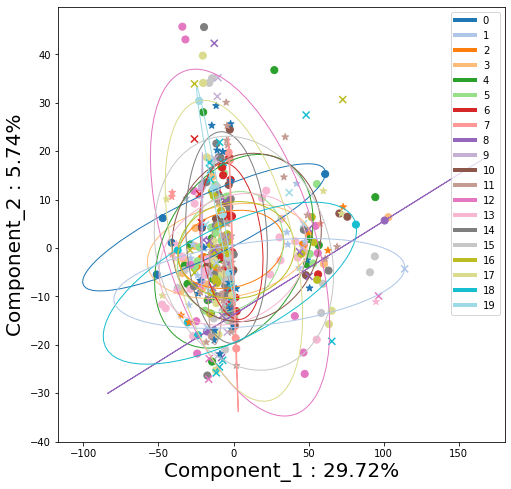

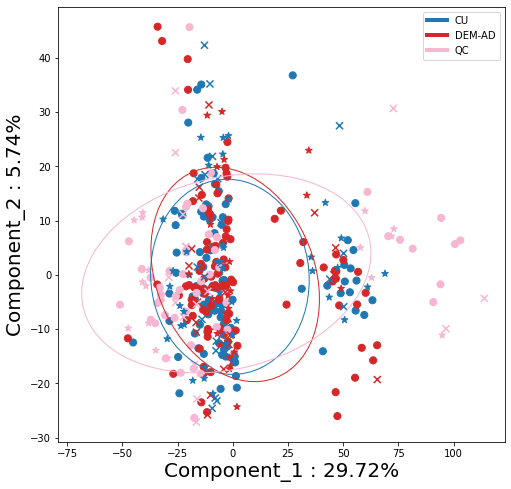

inputs train
inputs valid
inputs test
batches train
batches valid
batches test
labels train
labels valid
labels test


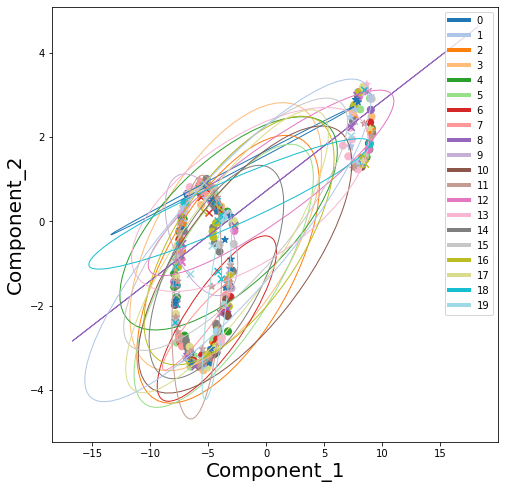

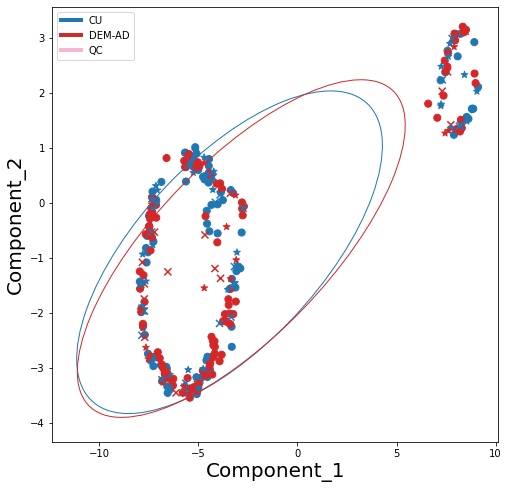

Iteration: 1
-1
valid_score: 0.07369550559872717 h_params: {'tol': 0.9744044165384433, 'max_iter': 933, 'penalty': 'l2', 'C': 9990.405154200935, 'class_weight': 'balanced'}
results/alzheimer/waveica/linsvc/2
Iteration: 2
[0.16791512356486687, -0.0657951694959769, 0.12892895218262657, 0.10250710695364046, 0.03492151478847891]
valid_score: 0.07333618421893917 h_params: {'tol': 0.0038576507737700483, 'max_iter': 389, 'penalty': 'l2', 'C': 9355.39077252125, 'class_weight': 'balanced'}
Iteration: 3
[0.16791512356486687, -0.0657951694959769, 0.12892895218262657, 0.10250710695364046, 0.03492151478847891]
valid_score: 0.152282164008721 h_params: {'tol': 0.0017909937393907646, 'max_iter': 525, 'penalty': 'l2', 'C': 2295.7729077210424, 'class_weight': 'balanced'}
results/alzheimer/waveica/linsvc/2
Iteration: 4
[0.0916441826577421, 0.11952286093343938, 0.07692442360381202, 0.3118047822311618, 0.16151457061744964]
valid_score: 0.058847564662215725 h_params: {'tol': 0.4527391991788818, 'max_iter': 

In [52]:
%matplotlib inline
metrics = log_fct(copy.deepcopy(data), unique_labels, 'waveica', metrics)
log_ord(copy.deepcopy(data), unique_labels, unique_batches)
train_fct(copy.deepcopy(data), n_meta, train_models, 'waveica')


In [53]:
if log_stuff:
    # table = pd.DataFrame(columns=list(metrics['raw']['all'].keys()) + ['delta', 'delta_pool'], index=list(metrics.keys()))
    cols = ['qc_aPCC', '[qc_dist/tot_eucl]', 'lisi', 'silhouette', 'kbet', 'shannon', 'adjusted_rand_score', 'adjusted_mutual_info_score']
    cols_pool = ['pool lisi', 'pool silhouette', 'pool kbet', 'pool shannon', 'pool adjusted_rand_score', 'pool adjusted_mutual_info_score',]
    table = pd.DataFrame(columns=cols + cols_pool, index=list(metrics.keys()))
    # table = table.drop(['qc_dist', 'b_euclidean', 'euclidean', "[b_euclidean/tot_eucl]"], 1)
    for col in cols:
        for row in list(table.index):
            # if 'delta' in col:
            #     table[col][row] = metrics[row][col]
            # else:
            try:
                if isinstance(metrics[row]['all'][col], dict):
                    table[col][row] = metrics[row]['all'][col]["domains"]
                    try:
                        table[f'pool {col}'][row] = metrics[row]['all_pool'][col]["domains"]
                    except:
                        pass
                    # table[col][row]["domains"] = metrics[row]['all'][col]["domains"]
                    # table[col][row]["labels"] = metrics[row]['all'][col]["labels"]
                else:
                    try:
                        table[col][row] = metrics[row]['valid'][col]
                    except:
                        table[col][row] = metrics[row]['all'][col]

            except:
                try:
                    table[col][row] = metrics[row]['all_pool'][col]
                except:
                    table[col][row] = metrics[row]['valid'][col]

table

qc_aPCC [qc_dist/tot_eucl]      lisi silhouette  \
raw                 0.732741           1.460764  2.187153  -0.037908   
minmax              0.599676           1.456087  3.627577  -0.033912   
minmax_per_batch    0.309229            3.52344  3.095426   0.000102   
standard            0.350528           1.216243  3.691392  -0.054379   
standard_per_batch  0.220291           3.421509  2.752286  -0.075957   
robust              0.260338           1.500414  4.404295  -0.130541   
robust_per_batch    0.181777           2.219816  3.909976  -0.251592   
combat             -0.004134            1.07311  1.514282  -0.099024   
pycombat            0.831693           1.426895    2.0285  -0.134733   
harmony             0.094506           0.997508   4.83336  -0.033484   
waveica             0.776453           1.397374  2.064762  -0.087247   

                        kbet   shannon adjusted_rand_score  \
raw                      0.0   2.20917            0.203972   
minmax                   0.0  2.193134            0.221304   
minmax_per_batch         0.0  2.283798            0.278065   
standard                 0.0  2.302151            0.200432   
standard_per_batch       0.0  2.487221            0.004316   
robust              0.143191  2.352545            0.069275   
robust_per_batch    0.065315  2.562912            0.004405   
combat                   0.0  2.697885           -0.002091   
pycombat                 0.0   2.34555            0.027693   
harmony             0.000024  2.777707            0.016139   
waveica                  0.0  2.314655            0.035948   

                   adjusted_mutual_info_score pool lisi pool silhouette  \
raw                                  0.377329       NaN             NaN   
minmax                               0.399033       NaN             NaN   
minmax_per_batch                     0.384261       NaN             NaN   
standard                             0.361991       NaN             NaN   
standard_per_batch                   0.012204       NaN             NaN   
robust                               0.190386       NaN             NaN   
robust_per_batch                     0.042722       NaN             NaN   
combat                              -0.003598       NaN             NaN   
pycombat                             0.097962       NaN             NaN   
harmony                              0.060555       NaN             NaN   
waveica                                 0.089       NaN             NaN   

                   pool kbet pool shannon pool adjusted_rand_score  \
raw                      NaN          NaN                      NaN   
minmax                   NaN          NaN                      NaN   
minmax_per_batch         NaN          NaN                      NaN   
standard                 NaN          NaN                      NaN   
standard_per_batch       NaN          NaN                      NaN   
robust                   NaN          NaN                      NaN   
robust_per_batch         NaN          NaN                      NaN   
combat                   NaN          NaN                      NaN   
pycombat                 NaN          NaN                      NaN   
harmony                  NaN          NaN                      NaN   
waveica                  NaN          NaN                      NaN   

                   pool adjusted_mutual_info_score  
raw                                            NaN  
minmax                                         NaN  
minmax_per_batch                               NaN  
standard                                       NaN  
standard_per_batch                             NaN  
robust                                         NaN  
robust_per_batch                               NaN  
combat                                         NaN  
pycombat                                       NaN  
harmony                                        NaN  
waveica                                        NaN

# AE 

In [54]:
from src.dl.models.pytorch.aedann import AutoEncoder2 as AutoEncoder


## Encoded

In [55]:
%matplotlib inline
path = 'data/Alzheimer'
data, unique_labels, unique_batches = get_alzheimer(path, args)
# unique_labels = get_unique_labels(data['labels']['all'])
unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
unique_ages = np.array(['50s', '60s', '70s', '80+'])
unique_genders = np.unique(data['meta']['all'].iloc[:, 1])
n_cats = len(unique_labels)
n_batches = len(unique_batches)
n_ages = len(unique_ages)
n_genders = len(unique_genders)

data['age'] = {}
data['gender'] = {}
meta_age = []
for age in data['meta']['all'].iloc[:, 0]:
    if age < 50:
        meta_age += ['pool']
    elif age < 60:
        meta_age += ['50s']
    elif age < 70:
        meta_age += ['60s']
    elif age < 80:
        meta_age += ['70s']
    else:
        meta_age += ['80+']
data['age']['all'] = np.array(meta_age)
data['gender']['all'] = data['meta']['all'].iloc[:, 1]

data, _ = scale_data('robust', data, device='cpu')

# Best score run Brain-1446
path='logs/best_models/ae_then_classifier_holdout/alzheimer/no_vae0/model_1.pth'
    
# best score is autoencoder0, best correction autoencoder3
best_ae2 = AutoEncoder(data['inputs']['all'].shape[1],
                    n_batches=22,
                    nb_classes=2,
                    layer1=1593,
                    mapper=0,
                    layer2=283,
                    dropout=0,
                    n_meta=0,
                    n_emb=2,
                    n_layers=2,
                    variational=0, conditional=False, zinb=0,
                    add_noise=0, tied_weights=0, 
                    use_gnn=0, device='cpu').to('cpu')

best_ae2.mapper.to('cpu')
best_ae2.dec.to('cpu')

best_ae2.load_state_dict(torch.load(f'{path}'))
best_ae2.eval()

batches = torch.Tensor([np.argwhere(unique_batches == x)[0][0] for x in data['batches']['all']]).detach().cpu()
enc_data = data.copy()
enc_data['inputs']['all'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all'].values), batches, sampling=True, mapping=False)
enc_data['inputs']['all_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all_pool'].values), batches, sampling=False, mapping=False)
enc_data['inputs']['train'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train'].values), batches, sampling=True, mapping=False)
enc_data['inputs']['train_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train_pool'].values), batches, sampling=False, mapping=False)
enc_data['inputs']['valid'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid'].values), batches, sampling=True, mapping=False)
enc_data['inputs']['valid_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid_pool'].values), batches, sampling=False, mapping=False)
enc_data['inputs']['test'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test'].values), batches, sampling=True, mapping=False)
enc_data['inputs']['test_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test_pool'].values), batches, sampling=False, mapping=False)

for group in enc_data['inputs']:
    enc_data['inputs'][group] = pd.DataFrame(enc_data['inputs'][group].detach().cpu().numpy())

metrics += [log_fct(copy.deepcopy(data), unique_labels, 'ae', metrics)]
log_ord(copy.deepcopy(data), unique_labels, unique_batches)
# train_fct(copy.deepcopy(data), n_meta, train_models, 'harmony')


RuntimeError: Error(s) in loading state_dict for AutoEncoder2:
	size mismatch for enc.linear1.0.weight: copying a param with shape torch.Size([548, 896]) from checkpoint, the shape in current model is torch.Size([1593, 896]).
	size mismatch for enc.linear1.0.bias: copying a param with shape torch.Size([548]) from checkpoint, the shape in current model is torch.Size([1593]).
	size mismatch for enc.linear1.1.weight: copying a param with shape torch.Size([548]) from checkpoint, the shape in current model is torch.Size([1593]).
	size mismatch for enc.linear1.1.bias: copying a param with shape torch.Size([548]) from checkpoint, the shape in current model is torch.Size([1593]).
	size mismatch for enc.linear1.1.running_mean: copying a param with shape torch.Size([548]) from checkpoint, the shape in current model is torch.Size([1593]).
	size mismatch for enc.linear1.1.running_var: copying a param with shape torch.Size([548]) from checkpoint, the shape in current model is torch.Size([1593]).
	size mismatch for enc.linear2.0.weight: copying a param with shape torch.Size([57, 548]) from checkpoint, the shape in current model is torch.Size([283, 1593]).
	size mismatch for enc.linear2.0.bias: copying a param with shape torch.Size([57]) from checkpoint, the shape in current model is torch.Size([283]).
	size mismatch for enc.linear2.1.weight: copying a param with shape torch.Size([57]) from checkpoint, the shape in current model is torch.Size([283]).
	size mismatch for enc.linear2.1.bias: copying a param with shape torch.Size([57]) from checkpoint, the shape in current model is torch.Size([283]).
	size mismatch for enc.linear2.1.running_mean: copying a param with shape torch.Size([57]) from checkpoint, the shape in current model is torch.Size([283]).
	size mismatch for enc.linear2.1.running_var: copying a param with shape torch.Size([57]) from checkpoint, the shape in current model is torch.Size([283]).
	size mismatch for dec.linear1.0.weight: copying a param with shape torch.Size([548, 57]) from checkpoint, the shape in current model is torch.Size([1593, 283]).
	size mismatch for dec.linear1.0.bias: copying a param with shape torch.Size([548]) from checkpoint, the shape in current model is torch.Size([1593]).
	size mismatch for dec.linear1.1.weight: copying a param with shape torch.Size([548]) from checkpoint, the shape in current model is torch.Size([1593]).
	size mismatch for dec.linear1.1.bias: copying a param with shape torch.Size([548]) from checkpoint, the shape in current model is torch.Size([1593]).
	size mismatch for dec.linear1.1.running_mean: copying a param with shape torch.Size([548]) from checkpoint, the shape in current model is torch.Size([1593]).
	size mismatch for dec.linear1.1.running_var: copying a param with shape torch.Size([548]) from checkpoint, the shape in current model is torch.Size([1593]).
	size mismatch for dec.linear2.0.weight: copying a param with shape torch.Size([896, 548]) from checkpoint, the shape in current model is torch.Size([896, 1593]).
	size mismatch for mapper.linear3.0.weight: copying a param with shape torch.Size([57, 23]) from checkpoint, the shape in current model is torch.Size([283, 23]).
	size mismatch for mapper.linear3.0.bias: copying a param with shape torch.Size([57]) from checkpoint, the shape in current model is torch.Size([283]).
	size mismatch for dann_discriminator.linear1.0.weight: copying a param with shape torch.Size([64, 57]) from checkpoint, the shape in current model is torch.Size([64, 283]).
	size mismatch for classifier.linear2.0.weight: copying a param with shape torch.Size([59, 59]) from checkpoint, the shape in current model is torch.Size([285, 285]).
	size mismatch for classifier.linear2.0.bias: copying a param with shape torch.Size([59]) from checkpoint, the shape in current model is torch.Size([285]).
	size mismatch for classifier.linear3.0.weight: copying a param with shape torch.Size([2, 59]) from checkpoint, the shape in current model is torch.Size([2, 285]).
	size mismatch for _dec_mean.0.weight: copying a param with shape torch.Size([896, 548]) from checkpoint, the shape in current model is torch.Size([896, 1593]).
	size mismatch for _dec_disp.0.weight: copying a param with shape torch.Size([896, 548]) from checkpoint, the shape in current model is torch.Size([896, 1593]).
	size mismatch for _dec_pi.0.weight: copying a param with shape torch.Size([896, 548]) from checkpoint, the shape in current model is torch.Size([896, 1593]).

# NORMAE 

In [ ]:
# from src.dl.models.pytorch.aedann import AutoEncoder2 as AutoEncoder


## Encoded

In [ ]:
%matplotlib inline
path = 'data/Alzheimer'
data, unique_labels, unique_batches = get_alzheimer(path, args)
# unique_labels = get_unique_labels(data['labels']['all'])
unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
unique_ages = np.array(['50s', '60s', '70s', '80+'])
unique_genders = np.unique(data['meta']['all'].iloc[:, 1])
n_cats = len(unique_labels)
n_batches = len(unique_batches)
n_ages = len(unique_ages)
n_genders = len(unique_genders)

data['age'] = {}
data['gender'] = {}
meta_age = []
for age in data['meta']['all'].iloc[:, 0]:
    if age < 50:
        meta_age += ['pool']
    elif age < 60:
        meta_age += ['50s']
    elif age < 70:
        meta_age += ['60s']
    elif age < 80:
        meta_age += ['70s']
    else:
        meta_age += ['80+']
data['age']['all'] = np.array(meta_age)
data['gender']['all'] = data['meta']['all'].iloc[:, 1]

data, _ = scale_data('standard', data, device='cpu')

path='logs/best_models/ae_then_classifier_holdout/alzheimer/normae_vae0/model_1.pth'
    
# best score is autoencoder0, best correction autoencoder3
best_ae2 = AutoEncoder(data['inputs']['all'].shape[1],
                    n_batches=22,
                    nb_classes=2,
                    layer1=745,
                    mapper=0,
                    layer2=474,
                    dropout=0,
                        n_meta=0,
                        n_emb=2,
                        n_layers=2,
                    variational=0, conditional=False, zinb=0,
                    add_noise=0, tied_weights=0, 
                    use_gnn=0, device='cpu').to('cpu')

best_ae2.mapper.to('cpu')
best_ae2.dec.to('cpu')

best_ae2.load_state_dict(torch.load(f'{path}'))
best_ae2.eval()


batches = torch.Tensor([np.argwhere(unique_batches == x)[0][0] for x in data['batches']['all']]).detach().cpu()
enc_data = data.copy()
enc_data['inputs']['all'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all'].values), batches, sampling=True)
enc_data['inputs']['all_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all_pool'].values), batches, sampling=False)
enc_data['inputs']['train'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train'].values), batches, sampling=True)
enc_data['inputs']['train_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train_pool'].values), batches, sampling=False)
enc_data['inputs']['valid'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid'].values), batches, sampling=True)
enc_data['inputs']['valid_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid_pool'].values), batches, sampling=False)
enc_data['inputs']['test'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test'].values), batches, sampling=True)
enc_data['inputs']['test_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test_pool'].values), batches, sampling=False)

for group in enc_data['inputs']:
    enc_data['inputs'][group] = pd.DataFrame(enc_data['inputs'][group].detach().cpu().numpy())

metrics = log_fct(copy.deepcopy(data), unique_labels, 'normae', metrics)
log_ord(copy.deepcopy(data), unique_labels, unique_batches)
# train_fct(copy.deepcopy(data), n_meta, train_models, 'normae')


# AEDANN

## Encoded

In [ ]:
path = 'data/Alzheimer'
data, unique_labels, unique_batches = get_alzheimer(path, args)
# unique_labels = get_unique_labels(data['labels']['all'])
unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
unique_ages = np.array(['50s', '60s', '70s', '80+'])
unique_genders = np.unique(data['meta']['all'].iloc[:, 1])
n_cats = len(unique_labels)
n_batches = len(unique_batches)
n_ages = len(unique_ages)
n_genders = len(unique_genders)

data['age'] = {}
data['gender'] = {}
meta_age = []
for age in data['meta']['all'].iloc[:, 0]:
    if age < 50:
        meta_age += ['pool']
    elif age < 60:
        meta_age += ['50s']
    elif age < 70:
        meta_age += ['60s']
    elif age < 80:
        meta_age += ['70s']
    else:
        meta_age += ['80+']
data['age']['all'] = np.array(meta_age)
data['gender']['all'] = data['meta']['all'].iloc[:, 1]

data, _ = scale_data('robust', data, device='cpu')

path='logs/best_models/ae_then_classifier_holdout/alzheimer/DANN_vae0/model_1.pth'
    
# best score is autoencoder0, best correction autoencoder3
best_ae2 = AutoEncoder(data['inputs']['all'].shape[1],
                    n_batches=22,
                    nb_classes=2,
                    layer1=745,
                    mapper=0,
                    layer2=474,
                    dropout=0,
                        n_meta=0,
                        n_emb=2,
                        n_layers=2,
                    variational=0, conditional=False, zinb=0,
                    add_noise=0, tied_weights=0, 
                    use_gnn=0, device='cpu').to('cpu')

best_ae2.mapper.to('cpu')
best_ae2.dec.to('cpu')

best_ae2.load_state_dict(torch.load(f'{path}', map_location='cpu'))
best_ae2.eval()
pass

In [ ]:
batches = torch.Tensor([np.argwhere(unique_batches == x)[0][0] for x in data['batches']['all']]).detach().cpu()
enc_data = data.copy()
enc_data['inputs']['all'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all'].values), batches, sampling=True, mapping=False)
enc_data['inputs']['all_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all_pool'].values), batches, sampling=True, mapping=False)
enc_data['inputs']['train'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train'].values), batches, sampling=True, mapping=False)
enc_data['inputs']['train_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train_pool'].values), batches, sampling=True, mapping=False)
enc_data['inputs']['valid'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid'].values), batches, sampling=True, mapping=False)
enc_data['inputs']['valid_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid_pool'].values), batches, sampling=True, mapping=False)
enc_data['inputs']['test'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test'].values), batches, sampling=True, mapping=False)
enc_data['inputs']['test_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test_pool'].values), batches, sampling=True, mapping=False)

for group in enc_data['inputs']:
    enc_data['inputs'][group] = pd.DataFrame(enc_data['inputs'][group].detach().cpu().numpy())

%matplotlib inline
metrics = log_fct(copy.deepcopy(data), unique_labels, 'aedann', metrics)
log_ord(copy.deepcopy(data), unique_labels, unique_batches)
# train_fct(copy.deepcopy(data), n_meta, train_models, 'normae')


# AE-invTriplet

## Encoded

In [ ]:
path = 'data/Alzheimer'
data, unique_labels, unique_batches = get_alzheimer(path, args)
# unique_labels = get_unique_labels(data['labels']['all'])
unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
unique_ages = np.array(['50s', '60s', '70s', '80+'])
unique_genders = np.unique(data['meta']['all'].iloc[:, 1])
n_cats = len(unique_labels)
n_batches = len(unique_batches)
n_ages = len(unique_ages)
n_genders = len(unique_genders)

data['age'] = {}
data['gender'] = {}
meta_age = []
for age in data['meta']['all'].iloc[:, 0]:
    if age < 50:
        meta_age += ['pool']
    elif age < 60:
        meta_age += ['50s']
    elif age < 70:
        meta_age += ['60s']
    elif age < 80:
        meta_age += ['70s']
    else:
        meta_age += ['80+']
data['age']['all'] = np.array(meta_age)
data['gender']['all'] = data['meta']['all'].iloc[:, 1]

data, _ = scale_data('standard', data, device='cpu')

path='logs/best_models/ae_then_classifier_holdout/alzheimer/inverseTriplet_vae0/model_1.pth'
    
# best score is autoencoder0, best correction autoencoder3
best_ae2 = AutoEncoder(data['inputs']['all'].shape[1],
                    n_batches=22,
                    nb_classes=2,
                    layer1=676,
                    mapper=0,
                    layer2=745,
                    dropout=0,
                        n_meta=0,
                        n_emb=2,
                        n_layers=2,
                    variational=0, conditional=False, zinb=0,
                    add_noise=0, tied_weights=0, 
                    use_gnn=0, device='cpu').to('cpu')

best_ae2.mapper.to('cpu')
best_ae2.dec.to('cpu')

best_ae2.load_state_dict(torch.load(f'{path}', map_location='cpu'))
best_ae2.eval()

batches = torch.Tensor([np.argwhere(unique_batches == x)[0][0] for x in data['batches']['all']]).detach().cpu()
enc_data = data.copy()
enc_data['inputs']['all'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all'].values), batches, sampling=True)
enc_data['inputs']['all_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all_pool'].values), batches, sampling=True)
enc_data['inputs']['train'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train'].values), batches, sampling=True)
enc_data['inputs']['train_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train_pool'].values), batches, sampling=True)
enc_data['inputs']['valid'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid'].values), batches, sampling=True)
enc_data['inputs']['valid_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid_pool'].values), batches, sampling=True)
enc_data['inputs']['test'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test'].values), batches, sampling=True)
enc_data['inputs']['test_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test_pool'].values), batches, sampling=True)

for group in enc_data['inputs']:
    enc_data['inputs'][group] = pd.DataFrame(enc_data['inputs'][group].detach().cpu().numpy())

%matplotlib inline
metrics = log_fct(copy.deepcopy(data), unique_labels, 'ae-invTriplet', metrics)
log_ord(copy.deepcopy(data), unique_labels, unique_batches)
# train_fct(copy.deepcopy(data), n_meta, train_models, 'normae')


# AE-revTriplet

## Encoded

In [ ]:
path = 'data/Alzheimer'
data, unique_labels, unique_batches = get_alzheimer(path, args)
# unique_labels = get_unique_labels(data['labels']['all'])
unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
unique_ages = np.array(['50s', '60s', '70s', '80+'])
unique_genders = np.unique(data['meta']['all'].iloc[:, 1])
n_cats = len(unique_labels)
n_batches = len(unique_batches)
n_ages = len(unique_ages)
n_genders = len(unique_genders)

data['age'] = {}
data['gender'] = {}
meta_age = []
for age in data['meta']['all'].iloc[:, 0]:
    if age < 50:
        meta_age += ['pool']
    elif age < 60:
        meta_age += ['50s']
    elif age < 70:
        meta_age += ['60s']
    elif age < 80:
        meta_age += ['70s']
    else:
        meta_age += ['80+']
data['age']['all'] = np.array(meta_age)
data['gender']['all'] = data['meta']['all'].iloc[:, 1]

data, _ = scale_data('standard', data, device='cpu')

path='logs/best_models/ae_then_classifier_holdout/alzheimer/revTriplet_vae0/model_1.pth'
    
# best score is autoencoder0, best correction autoencoder3
best_ae2 = AutoEncoder(data['inputs']['all'].shape[1],
                    n_batches=22,
                    nb_classes=2,
                    layer1=1137,
                    mapper=0,
                    layer2=260,
                    dropout=0,
                        n_meta=0,
                        n_emb=2,
                        n_layers=2,
                    variational=0, conditional=False, zinb=0,
                    add_noise=0, tied_weights=0, 
                    use_gnn=0, device='cpu').to('cpu')

best_ae2.mapper.to('cpu')
best_ae2.dec.to('cpu')

best_ae2.load_state_dict(torch.load(f'{path}', map_location='cpu'))
best_ae2.eval()

batches = torch.Tensor([np.argwhere(unique_batches == x)[0][0] for x in data['batches']['all']]).detach().cpu()
enc_data = data.copy()
enc_data['inputs']['all'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all'].values), batches, sampling=True)
enc_data['inputs']['all_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all_pool'].values), batches, sampling=False)
enc_data['inputs']['train'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train'].values), batches, sampling=True)
enc_data['inputs']['train_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train_pool'].values), batches, sampling=False)
enc_data['inputs']['valid'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid'].values), batches, sampling=True)
enc_data['inputs']['valid_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid_pool'].values), batches, sampling=False)
enc_data['inputs']['test'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test'].values), batches, sampling=True)
enc_data['inputs']['test_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test_pool'].values), batches, sampling=False)

for group in enc_data['inputs']:
    enc_data['inputs'][group] = pd.DataFrame(enc_data['inputs'][group].detach().cpu().numpy())

%matplotlib inline
metrics = log_fct(copy.deepcopy(data), unique_labels, 'ae-revTriplet', metrics)
log_ord(copy.deepcopy(data), unique_labels, unique_batches)
# train_fct(copy.deepcopy(data), n_meta, train_models, 'normae')


# NORMVAE

## Encoded

In [ ]:
%matplotlib inline

path = 'data/Alzheimer'
data, unique_labels, unique_batches = get_alzheimer(path, args)
# unique_labels = get_unique_labels(data['labels']['all'])
unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
unique_ages = np.array(['50s', '60s', '70s', '80+'])
unique_genders = np.unique(data['meta']['all'].iloc[:, 1])
n_cats = len(unique_labels)
n_batches = len(unique_batches)
n_ages = len(unique_ages)
n_genders = len(unique_genders)

data['age'] = {}
data['gender'] = {}
meta_age = []
for age in data['meta']['all'].iloc[:, 0]:
    if age < 50:
        meta_age += ['pool']
    elif age < 60:
        meta_age += ['50s']
    elif age < 70:
        meta_age += ['60s']
    elif age < 80:
        meta_age += ['70s']
    else:
        meta_age += ['80+']
data['age']['all'] = np.array(meta_age)
data['gender']['all'] = data['meta']['all'].iloc[:, 1]

data, _ = scale_data('standard', data, device='cpu')

path='logs/best_models/ae_then_classifier_holdout/alzheimer/normae_vae1/model_1.pth'
    
# best score is autoencoder0, best correction autoencoder3
best_ae2 = AutoEncoder(data['inputs']['all'].shape[1],
                    n_batches=22,
                    nb_classes=2,
                    layer1=1427,
                    mapper=0,
                    layer2=353,
                    dropout=0,
                        n_meta=0,
                        n_emb=2,
                        n_layers=2,
                    variational=1, conditional=False, zinb=0,
                    add_noise=0, tied_weights=0, 
                    use_gnn=0, device='cpu').to('cpu')

best_ae2.load_state_dict(torch.load(f'{path}', map_location='cpu'))
best_ae2.mapper.to('cpu')
best_ae2.dec.to('cpu')

best_ae2.eval()

batches = torch.Tensor([np.argwhere(unique_batches == x)[0][0] for x in data['batches']['all']]).detach().cpu()
enc_data = data.copy()
enc_data['inputs']['all'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all'].values), batches, sampling=False)
enc_data['inputs']['all_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all_pool'].values), batches, sampling=False)
enc_data['inputs']['train'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train'].values), batches, sampling=False)
enc_data['inputs']['train_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train_pool'].values), batches, sampling=False)
enc_data['inputs']['valid'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid'].values), batches, sampling=False)
enc_data['inputs']['valid_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid_pool'].values), batches, sampling=False)
enc_data['inputs']['test'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test'].values), batches, sampling=False)
enc_data['inputs']['test_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test_pool'].values), batches, sampling=False)

for group in enc_data['inputs']:
    enc_data['inputs'][group] = pd.DataFrame(enc_data['inputs'][group].detach().cpu().numpy())

metrics = log_fct(copy.deepcopy(data), unique_labels, 'normvae', metrics)
log_ord(copy.deepcopy(data), unique_labels, unique_batches)
# train_fct(copy.deepcopy(data), n_meta, train_models, 'normae')


# VAE

## Encoded

In [ ]:
%matplotlib inline
path = 'data/Alzheimer'
data, unique_labels, unique_batches = get_alzheimer(path, args)
# unique_labels = get_unique_labels(data['labels']['all'])
unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
unique_ages = np.array(['50s', '60s', '70s', '80+'])
unique_genders = np.unique(data['meta']['all'].iloc[:, 1])
n_cats = len(unique_labels)
n_batches = len(unique_batches)
n_ages = len(unique_ages)
n_genders = len(unique_genders)

data['age'] = {}
data['gender'] = {}
meta_age = []
for age in data['meta']['all'].iloc[:, 0]:
    if age < 50:
        meta_age += ['pool']
    elif age < 60:
        meta_age += ['50s']
    elif age < 70:
        meta_age += ['60s']
    elif age < 80:
        meta_age += ['70s']
    else:
        meta_age += ['80+']
data['age']['all'] = np.array(meta_age)
data['gender']['all'] = data['meta']['all'].iloc[:, 1]

data, _ = scale_data('standard', data, device='cpu')

path='logs/best_models/ae_then_classifier_holdout/alzheimer/no_vae1/model_1.pth'

# best score is autoencoder0, best correction autoencoder3
best_ae2 = AutoEncoder(data['inputs']['all'].shape[1],
                    n_batches=22,
                    nb_classes=2,
                    layer1=1137,
                    mapper=0,
                    layer2=260,
                    dropout=0,
                        n_meta=0,
                        n_emb=2,
                        n_layers=2,
                    variational=1, conditional=False, zinb=0,
                    add_noise=0, tied_weights=0, 
                    use_gnn=0, device='cpu').to('cpu')

best_ae2.load_state_dict(torch.load(f'{path}', map_location='cpu'))
best_ae2.mapper.to('cpu')
best_ae2.dec.to('cpu')

best_ae2.eval()

batches = torch.Tensor([np.argwhere(unique_batches == x)[0][0] for x in data['batches']['all']]).detach().cpu()
enc_data = data.copy()
enc_data['inputs']['all'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all'].values), batches, sampling=False)
enc_data['inputs']['all_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all_pool'].values), batches, sampling=False)
enc_data['inputs']['train'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train'].values), batches, sampling=False)
enc_data['inputs']['train_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train_pool'].values), batches, sampling=False)
enc_data['inputs']['valid'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid'].values), batches, sampling=False)
enc_data['inputs']['valid_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid_pool'].values), batches, sampling=False)
enc_data['inputs']['test'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test'].values), batches, sampling=False)
enc_data['inputs']['test_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test_pool'].values), batches, sampling=False)

for group in enc_data['inputs']:
    enc_data['inputs'][group] = pd.DataFrame(enc_data['inputs'][group].detach().cpu().numpy())

metrics = log_fct(copy.deepcopy(data), unique_labels, 'vae', metrics)
log_ord(copy.deepcopy(data), unique_labels, unique_batches)
# train_fct(copy.deepcopy(data), n_meta, train_models, 'normae')


# VAEDANN

## Encoded

In [ ]:
%matplotlib inline
path = 'data/Alzheimer'
data, unique_labels, unique_batches = get_alzheimer(path, args)
# unique_labels = get_unique_labels(data['labels']['all'])
unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
unique_ages = np.array(['50s', '60s', '70s', '80+'])
unique_genders = np.unique(data['meta']['all'].iloc[:, 1])
n_cats = len(unique_labels)
n_batches = len(unique_batches)
n_ages = len(unique_ages)
n_genders = len(unique_genders)

data['age'] = {}
data['gender'] = {}
meta_age = []
for age in data['meta']['all'].iloc[:, 0]:
    if age < 50:
        meta_age += ['pool']
    elif age < 60:
        meta_age += ['50s']
    elif age < 70:
        meta_age += ['60s']
    elif age < 80:
        meta_age += ['70s']
    else:
        meta_age += ['80+']
data['age']['all'] = np.array(meta_age)
data['gender']['all'] = data['meta']['all'].iloc[:, 1]

data, _ = scale_data('standard', data, device='cpu')

path='logs/best_models/ae_then_classifier_holdout/alzheimer/DANN_vae1/model_1.pth'
    
# best score is autoencoder0, best correction autoencoder3
best_ae2 = AutoEncoder(data['inputs']['all'].shape[1],
                    n_batches=22,
                    nb_classes=2,
                    layer1=1427,
                    mapper=0,
                    layer2=353,
                    dropout=0,
                        n_meta=0,
                        n_emb=2,
                        n_layers=2,
                    variational=1, conditional=False, zinb=0,
                    add_noise=0, tied_weights=0, 
                    use_gnn=0, device='cpu').to('cpu')

best_ae2.mapper.to('cpu')
best_ae2.dec.to('cpu')

best_ae2.load_state_dict(torch.load(f'{path}', map_location='cpu'))
best_ae2.eval()

batches = torch.Tensor([np.argwhere(unique_batches == x)[0][0] for x in data['batches']['all']]).detach().cpu()
enc_data = data.copy()
enc_data['inputs']['all'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all'].values), batches, sampling=False)
enc_data['inputs']['all_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all_pool'].values), batches, sampling=False)
enc_data['inputs']['train'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train'].values), batches, sampling=False)
enc_data['inputs']['train_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train_pool'].values), batches, sampling=False)
enc_data['inputs']['valid'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid'].values), batches, sampling=False)
enc_data['inputs']['valid_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid_pool'].values), batches, sampling=False)
enc_data['inputs']['test'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test'].values), batches, sampling=False)
enc_data['inputs']['test_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test_pool'].values), batches, sampling=False)

for group in enc_data['inputs']:
    enc_data['inputs'][group] = pd.DataFrame(enc_data['inputs'][group].detach().cpu().numpy())
metrics = log_fct(copy.deepcopy(data), unique_labels, 'vaedann', metrics)
log_ord(copy.deepcopy(data), unique_labels, unique_batches)
# train_fct(copy.deepcopy(data), n_meta, train_models, 'normae')


# VAE-invTriplet

## Encoded

In [ ]:
path = 'data/Alzheimer'
data, unique_labels, unique_batches = get_alzheimer(path, args)
# unique_labels = get_unique_labels(data['labels']['all'])
unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
unique_ages = np.array(['50s', '60s', '70s', '80+'])
unique_genders = np.unique(data['meta']['all'].iloc[:, 1])
n_cats = len(unique_labels)
n_batches = len(unique_batches)
n_ages = len(unique_ages)
n_genders = len(unique_genders)

data['age'] = {}
data['gender'] = {}
meta_age = []
for age in data['meta']['all'].iloc[:, 0]:
    if age < 50:
        meta_age += ['pool']
    elif age < 60:
        meta_age += ['50s']
    elif age < 70:
        meta_age += ['60s']
    elif age < 80:
        meta_age += ['70s']
    else:
        meta_age += ['80+']
data['age']['all'] = np.array(meta_age)
data['gender']['all'] = data['meta']['all'].iloc[:, 1]

data, _ = scale_data('standard', data, device='cpu')

path='logs/best_models/ae_then_classifier_holdout/alzheimer/inverseTriplet_vae1/model_1.pth'

# best score is autoencoder0, best correction autoencoder3
best_ae2 = AutoEncoder(data['inputs']['all'].shape[1],
                    n_batches=22,
                    nb_classes=2,
                    layer1=1930,
                    mapper=0,
                    layer2=372,
                    dropout=0,
                        n_meta=0,
                        n_emb=2,
                        n_layers=2,
                    variational=1, conditional=False, zinb=0,
                    add_noise=0, tied_weights=0, 
                    use_gnn=0, device='cpu').to('cpu')

best_ae2.mapper.to('cpu')
best_ae2.dec.to('cpu')

best_ae2.load_state_dict(torch.load(f'{path}', map_location='cpu'))
best_ae2.eval()


batches = torch.Tensor([np.argwhere(unique_batches == x)[0][0] for x in data['batches']['all']]).detach().cpu()
enc_data = data.copy()
enc_data['inputs']['all'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all'].values), batches, sampling=False)
enc_data['inputs']['all_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all_pool'].values), batches, sampling=False)
enc_data['inputs']['train'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train'].values), batches, sampling=False)
enc_data['inputs']['train_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train_pool'].values), batches, sampling=False)
enc_data['inputs']['valid'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid'].values), batches, sampling=False)
enc_data['inputs']['valid_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid_pool'].values), batches, sampling=False)
enc_data['inputs']['test'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test'].values), batches, sampling=False)
enc_data['inputs']['test_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test_pool'].values), batches, sampling=False)

for group in enc_data['inputs']:
    enc_data['inputs'][group] = pd.DataFrame(enc_data['inputs'][group].detach().cpu().numpy())

%matplotlib inline
metrics = log_fct(copy.deepcopy(data), unique_labels, 'vae-invTriplet', metrics)
log_ord(copy.deepcopy(data), unique_labels, unique_batches)
# train_fct(copy.deepcopy(data), n_meta, train_models, 'normae')


# VAE-revTriplet

## Encoded

In [ ]:
path = 'data/Alzheimer'
data, unique_labels, unique_batches = get_alzheimer(path, args)
# unique_labels = get_unique_labels(data['labels']['all'])
unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
unique_ages = np.array(['50s', '60s', '70s', '80+'])
unique_genders = np.unique(data['meta']['all'].iloc[:, 1])
n_cats = len(unique_labels)
n_batches = len(unique_batches)
n_ages = len(unique_ages)
n_genders = len(unique_genders)

data['age'] = {}
data['gender'] = {}
meta_age = []
for age in data['meta']['all'].iloc[:, 0]:
    if age < 50:
        meta_age += ['pool']
    elif age < 60:
        meta_age += ['50s']
    elif age < 70:
        meta_age += ['60s']
    elif age < 80:
        meta_age += ['70s']
    else:
        meta_age += ['80+']
data['age']['all'] = np.array(meta_age)
data['gender']['all'] = data['meta']['all'].iloc[:, 1]

data, _ = scale_data('standard', data, device='cpu')

path='logs/best_models/ae_then_classifier_holdout/alzheimer/revTriplet_vae1/model_1.pth'
# best score is autoencoder0, best correction autoencoder3
best_ae2 = AutoEncoder(data['inputs']['all'].shape[1],
                    n_batches=22,
                    nb_classes=2,
                    layer1=561,
                    mapper=0,
                    layer2=893,
                    dropout=0,
                        n_meta=0,
                        n_emb=2,
                        n_layers=2,
                    variational=1, conditional=False, zinb=0,
                    add_noise=0, tied_weights=0, 
                    use_gnn=0, device='cpu').to('cpu')

best_ae2.mapper.to('cpu')
best_ae2.dec.to('cpu')

best_ae2.load_state_dict(torch.load(f'{path}', map_location='cpu'))
best_ae2.eval()
pass

In [ ]:
batches = torch.Tensor([np.argwhere(unique_batches == x)[0][0] for x in data['batches']['all']]).detach().cpu()
enc_data = data.copy()
enc_data['inputs']['all'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all'].values), batches, sampling=False)
enc_data['inputs']['all_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all_pool'].values), batches, sampling=False)
enc_data['inputs']['train'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train'].values), batches, sampling=False)
enc_data['inputs']['train_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train_pool'].values), batches, sampling=False)
enc_data['inputs']['valid'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid'].values), batches, sampling=False)
enc_data['inputs']['valid_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid_pool'].values), batches, sampling=False)
enc_data['inputs']['test'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test'].values), batches, sampling=False)
enc_data['inputs']['test_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test_pool'].values), batches, sampling=False)

for group in enc_data['inputs']:
    enc_data['inputs'][group] = pd.DataFrame(enc_data['inputs'][group].detach().cpu().numpy())


In [ ]:
%matplotlib inline
metrics = log_fct(copy.deepcopy(data), unique_labels, 'vae-revTriplet', metrics)
log_ord(copy.deepcopy(data), unique_labels, unique_batches)
# train_fct(copy.deepcopy(data), n_meta, train_models, 'normae')


# Table

In [ ]:
if log_stuff:
    cols = ['qc_aPCC', '[qc_dist/tot_eucl]', 'lisi', 'silhouette', 'kbet', 'shannon', 'adjusted_rand_score', 'adjusted_mutual_info_score']
    cols_pool = ['pool lisi', 'pool silhouette', 'pool kbet', 'pool shannon', 'pool adjusted_rand_score', 'pool adjusted_mutual_info_score',]
    table = pd.DataFrame(columns=cols + cols_pool, index=list(metrics.keys()))
    # table = table.drop(['qc_dist', 'b_euclidean', 'euclidean', "[b_euclidean/tot_eucl]"], 1)
    for col in cols:
        for row in list(table.index):
            # if 'delta' in col:
            #     table[col][row] = metrics[row][col]
            # else:
            try:
                if isinstance(metrics[row]['all'][col], dict):
                    table[col][row] = metrics[row]['all'][col]["domains"]
                    try:
                        table[f'pool {col}'][row] = metrics[row]['all_pool'][col]["domains"]
                    except:
                        pass
                    # table[col][row]["domains"] = metrics[row]['all'][col]["domains"]
                    # table[col][row]["labels"] = metrics[row]['all'][col]["labels"]
                else:
                    try:
                        table[col][row] = metrics[row]['valid'][col]
                    except:
                        table[col][row] = metrics[row]['all'][col]

            except:
                try:
                    table[col][row] = metrics[row]['all_pool'][col]
                except:
                    table[col][row] = metrics[row]['valid'][col]

table

qc_aPCC [qc_dist/tot_eucl]      lisi silhouette  \
normvae-enc         0.211387           0.733643  4.543066  -0.407639   
vae-enc             0.906301           1.205846  3.583114  -0.484229   
vaedann-enc         0.991728            0.55049  5.061717  -0.236853   
vae-invTriplet-enc  0.713323           0.316828  4.498409  -0.302879   
vae-revTriplet-enc  0.962797           0.676141  4.010487  -0.409108   

                        kbet   shannon adjusted_rand_score  \
normvae-enc         0.438695  2.532785            0.036713   
vae-enc             0.673215  2.377873            0.077848   
vaedann-enc         0.436708   2.49558            0.049584   
vae-invTriplet-enc  0.085092  2.575598            0.030589   
vae-revTriplet-enc  0.433351  2.490597            0.045074   

                   adjusted_mutual_info_score pool lisi pool silhouette  \
normvae-enc                          0.088555       NaN             NaN   
vae-enc                              0.184842       NaN             NaN   
vaedann-enc                           0.12387       NaN             NaN   
vae-invTriplet-enc                   0.073455       NaN             NaN   
vae-revTriplet-enc                   0.107809       NaN             NaN   

                   pool kbet pool shannon pool adjusted_rand_score  \
normvae-enc              NaN          NaN                      NaN   
vae-enc                  NaN          NaN                      NaN   
vaedann-enc              NaN          NaN                      NaN   
vae-invTriplet-enc       NaN          NaN                      NaN   
vae-revTriplet-enc       NaN          NaN                      NaN   

                   pool adjusted_mutual_info_score  
normvae-enc                                    NaN  
vae-enc                                        NaN  
vaedann-enc                                    NaN  
vae-invTriplet-enc                             NaN  
vae-revTriplet-enc                             NaN

In [ ]:
table.to_csv('logs/alzheimer_metrics.csv')